In [1]:
import sklearn
import platform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import time
import datetime

In [2]:
#define path to raw data
base_path_0 = "C:/Users/dsosa/Documents/augment-projects/cbonds-comparables/data/raw"  


In [3]:
#load data from path
comparables_ytm = pd.read_csv(os.path.join(base_path_0, "comparables_ytm_hist.csv"), delimiter=",", header=0, low_memory=False)
comparables_names = pd.read_csv(os.path.join(base_path_0, "comparables_names.csv"), delimiter=",", header=0, low_memory=False)
panama_globales = pd.read_csv(os.path.join(base_path_0, "panama_globales_hist.csv"), delimiter=",", header=0, low_memory=False)
latinex_hist = pd.read_csv(os.path.join(base_path_0, "latinex_data_latest_version.csv"), delimiter=",", header=0, low_memory=False)

In [4]:
latinex_hist.head(5)

Fecha de TX  Transacción        Mercado               Emisor  \
0   1/10/2014        76264  M. Secundario  República de Panamá   
1   1/15/2014        76332  M. Secundario  República de Panamá   
2   1/15/2014        76333  M. Secundario  República de Panamá   
3   1/15/2014        76334  M. Secundario  República de Panamá   
4   1/16/2014        76380  M. Secundario  República de Panamá   

        Instrumento    Renta Resolución          ISIN    Sector  \
0  Notas del Tesoro  R. fija    Decreto  PAL634445MA6  Gobierno   
1  Bonos del Tesoro  R. fija   DECRET46  PAL634445NA4  Gobierno   
2  Bonos del Tesoro  R. fija   DECRET46  PAL634445NA4  Gobierno   
3  Bonos del Tesoro  R. fija   DECRET46  PAL634445NA4  Gobierno   
4  Notas del Tesoro  R. fija    Decreto  PAL634445MA6  Gobierno   

  Fecha de vencimiento   Precio  Cupón Valor nominal Valor transado    YTM  
0            6/15/2018  107.50%  5.00%     50,000.00      53,750.00  3.19%  
1            7/25/2022  107.25%  5.63%    500,000.00     536,250.00  4.61%  
2            7/25/2022  107.25%  5.63%    200,000.00     214,500.00  4.61%  
3            7/25/2022  107.25%  5.63%    300,000.00     321,750.00  4.61%  
4            6/15/2018  107.25%  5.00%  2,000,000.00   2,145,000.00  3.24%

In [5]:
#print shape of dataframes
print("comparables_ytm shape ----->", comparables_ytm.shape)
print("comparables_names shape ----->", comparables_names.shape)
print("panama_globales shape ----->", panama_globales.shape)
print("latinex_hist shape ----->", latinex_hist.shape)

comparables_ytm shape -----> (2805, 113)
comparables_names shape -----> (112, 20)
panama_globales shape -----> (2818, 32)
latinex_hist shape -----> (6328, 15)


In [6]:
# replace 'Corp' in dataset in any place where they are
comparables_ytm.columns = comparables_ytm.columns.str.replace("Corp", "").copy()
comparables_names.columns = comparables_names.columns.str.replace("Corp", "").copy()
panama_globales.columns = panama_globales.columns.str.replace("Corp", "").copy()
latinex_hist.columns = latinex_hist.columns.str.replace("Corp", "").copy()

In [7]:
# Extract ISSUE_DT and MATURITY from the first two rows
issue_dt = panama_globales.iloc[0, 1:].values
maturity = panama_globales.iloc[1, 1:].values

In [8]:
# Create a new DataFrame for the main data starting from the third row
main_data = panama_globales.iloc[2:].reset_index(drop=True)

In [9]:
# Set the column names for the main data
main_data.columns = ["Dates"] + list(main_data.columns[1:])

In [10]:
# Melt the DataFrame to get 'Isin' and 'ytm'
melted_data = main_data.melt(id_vars=["Dates"], var_name="Isin", value_name="ytm")

In [11]:
# Create a dictionary to map Isin to ISSUE_DT and MATURITY
isin_map = {
    isin: {"ISSUE_DT": issue, "MATURITY": mat}
    for isin, issue, mat in zip(main_data.columns[1:], issue_dt, maturity)
}

In [12]:
# Add ISSUE_DT and MATURITY columns
melted_data["ISSUE_DT"] = melted_data["Isin"].map(lambda x: isin_map[x]["ISSUE_DT"])
melted_data["MATURITY"] = melted_data["Isin"].map(lambda x: isin_map[x]["MATURITY"])

In [13]:
# Convert 'Dates' to datetime
melted_data["Dates"] = pd.to_datetime(melted_data["Dates"])

# Convert 'ytm' to float, replacing empty strings with NaN
melted_data["ytm"] = pd.to_numeric(melted_data["ytm"], errors="coerce")

# Convert 'ISSUE_DT' and 'MATURITY' to datetime
melted_data["ISSUE_DT"] = pd.to_datetime(melted_data["ISSUE_DT"], errors="coerce")
melted_data["MATURITY"] = pd.to_datetime(melted_data["MATURITY"], errors="coerce")

# Sort the DataFrame
melted_data = melted_data.sort_values(["Dates", "Isin"]).reset_index(drop=True)

In [14]:
# rename melted_data and rename 'Dates' by 'date'
melted_data.rename(columns={"Dates": "date"}, inplace=True)

In [15]:
# define panama_blobales_ytm
panama_ytm_globales = melted_data.copy()

In [16]:
# drop spaces in columns names and drop 'corp' word
comparables_ytm.columns = comparables_ytm.columns.str.replace(" ", "").copy()
comparables_ytm.columns = comparables_ytm.columns.str.replace("corp", "").copy()
# rename all columns names
comparables_names.columns = comparables_names.columns.str.lower().str.replace(" ", "_")

In [17]:
# define date format
comparables_ytm["date"] = pd.to_datetime(
    comparables_ytm["date"], format="%m/%d/%Y"
).dt.strftime("%Y-%m-%d")

# transform date columns
comparables_names["issue_date"] = pd.to_datetime(
    comparables_names["issue_date"], format="%m/%d/%Y"
).dt.strftime("%Y-%m-%d")
comparables_names["maturity_2"] = pd.to_datetime(
    comparables_names["maturity_2"], format="%m/%d/%Y"
).dt.strftime("%Y-%m-%d")

In [18]:
from datetime import datetime

fecha_actual = datetime(2025, 5, 20)

# Calcular el tiempo hasta el vencimiento en años
# The 'MATURITY' column already contains Timestamp objects, so no need for strptime
panama_ytm_globales["time_to_maturity"] = panama_ytm_globales["MATURITY"].apply(
    lambda x: (x - fecha_actual).days / 365
)

In [19]:
# round time_to_maturity in case of
panama_ytm_globales["time_to_maturity_rounded"] = panama_ytm_globales[
    "time_to_maturity"
].round()

In [20]:
# bond_category equal to tresury
def categorize_bond(years):
    if years <= 0:
        return 0  # Matured bonds
    elif years <= 1:
        return 1  # 1-year bonds
    elif years <= 2:
        return 2  # 2-year bonds
    elif years <= 3:
        return 3  # 3-year bonds
    elif years <= 5:
        return 5  # 5-year bonds
    elif years <= 7:
        return 7  # 7-year bonds
    elif years <= 10:
        return 10  # 10-year bonds
    elif years <= 20:
        return 20  # 20-year bonds
    elif years <= 30:
        return 30  # 20-year bonds
    else:
        return 50  # Bonds longer than 30 years

In [21]:
# Apply the function to create a new column
comparables_names["bond_category"] = comparables_names["years"].apply(categorize_bond)

In [22]:
# %%
def categorize_bond_term(years):
    if years <= 0:
        return "Matured"
    elif years <= 4:
        return "short_term"
    elif years <= 12:
        return "medium_term"
    elif years <= 21:
        return "medium_long_term"
    elif years <= 30:
        return "long_term"
    elif years <= 38:
        return "very_long_term"
    else:
        return "super_ultra_long_term"


# Apply the function to create a new column
comparables_names["bond_term_category"] = comparables_names["years"].apply(
    categorize_bond_term
)

In [23]:
# create a new column in case, that identifies whether a bond has ended or still has remaining time based on the 'years' column
comparables_names["bond_status"] = comparables_names["years"].apply(
    lambda x: "Ended" if x < 0 else "Remaining"
)


In [24]:
# Melt comparables_ytm
comparables_ytm_melt = pd.melt(
    comparables_ytm, id_vars=["date"], var_name="id_isin", value_name="ytm"
)

In [25]:
# drop where 'id_isin' = 'XS2523328479'
comparables_ytm_melt = comparables_ytm_melt[
    comparables_ytm_melt["id_isin"] != "XS2523328479"
]

In [26]:
# merge dataframes
final_comparables_ytm = comparables_ytm_melt.merge(
    comparables_names[
        [
            "id_isin",
            "issue_date",
            "ticker",
            "fitch_rating",
            "moody_rtg",
            "s&p_rating",
            "maturity_2",
            "years",
            "bond_category",
            "bond_term_category",
            "bond_status",
        ]
    ],
    on="id_isin",
    how="left",
)

In [27]:
# to datetime
final_comparables_ytm["date"] = pd.to_datetime(final_comparables_ytm["date"])
final_comparables_ytm["issue_date"] = pd.to_datetime(
    final_comparables_ytm["issue_date"]
)
final_comparables_ytm["maturity_2"] = pd.to_datetime(
    final_comparables_ytm["maturity_2"]
)

In [28]:
# Create a dictionary to map country names
countries_mapping = {
    "BRAZIL": "brasil",
    "CHILE": "chile",
    "COLOM": "colombia",
    "INDON": "indonesia",
    "PERU": "peru",
    "DOMREP": "rd",
    "ELSALV": "salvador",
    "COSTAR": "crc",
    "MEX": "mexico",
}

In [29]:
# Rename the 'maturity_2' column to 'maturity'
final_comparables_ytm.rename(columns={"maturity_2": "maturity"}, inplace=True)

# %%
# Replace the names in the ticker column using the mapping
final_comparables_ytm["country"] = final_comparables_ytm["ticker"].replace(
    countries_mapping
)

# %%
# convert to datitime 'date', 'issue_date' and 'maturity'
final_comparables_ytm["date"] = pd.to_datetime(final_comparables_ytm["date"])
final_comparables_ytm["maturity"] = pd.to_datetime(final_comparables_ytm["maturity"])
final_comparables_ytm["issue_date"] = pd.to_datetime(
    final_comparables_ytm["issue_date"]
)

In [30]:
# drop ticker column
final_comparables_ytm.drop(columns=["ticker"], inplace=True)

In [31]:
# order columns
order_columns = [
    "date",
    "id_isin",
    "ytm",
    "country",
    "issue_date",
    "maturity",
    "bond_status",
    "years",
    "bond_category",
    "bond_term_category",
    "fitch_rating",
    "moody_rtg",
    "s&p_rating",
]
final_comparables_ytm = final_comparables_ytm[order_columns]

In [32]:
# check NaN
final_comparables_ytm.isnull().sum()

# %%
# describe 'ytm' values diferent fom -999
final_comparables_ytm["ytm"].describe()

# %%
# Filtrar valores diferentes de -999 para los cálculos
valid_ytm = final_comparables_ytm[final_comparables_ytm["ytm"] != -999]["ytm"]


In [33]:
# Calcular Q1, Q3 e IQR para los valores válidos
Q1 = valid_ytm.quantile(0.25)
Q3 = valid_ytm.quantile(0.75)
IQR = Q3 - Q1

# %%
# Calcular los límites inferior y superior
lower_fence = Q1 - 1.5 * IQR
upper_fence = Q3 + 1.5 * IQR

# %%
# Crear una nueva columna 'is_anomaly' para identificar anomalías
final_comparables_ytm["is_anomaly"] = np.where(
    (final_comparables_ytm["ytm"] != -999)
    & (
        (final_comparables_ytm["ytm"] < lower_fence)
        | (final_comparables_ytm["ytm"] > upper_fence)
    ),
    1,  # Es una anomalía
    0,  # No es una anomalía
)

In [34]:
# create a new dataframe with out anomalies
lat_bonds = final_comparables_ytm[final_comparables_ytm["is_anomaly"] == 0]

In [35]:
# only ytm>0
lat_bonds = lat_bonds[lat_bonds["ytm"] > 0]

In [36]:
# create a new dataframe with out anomalies for panama globales
panama_globales_bonds = panama_ytm_globales.copy()
panama_globales_bonds["ytm"] = panama_globales_bonds["ytm"].astype(float)

In [37]:
panama_globales_bonds

date       Isin    ytm   ISSUE_DT   MATURITY  time_to_maturity  \
0     2014-09-09  AN475422     NaN 2017-05-15 2047-05-15         22.000000   
1     2014-09-09  AS150869     NaN 2018-04-16 2050-04-16         24.923288   
2     2014-09-09  AZ702867     NaN 2019-07-23 2030-01-23          4.682192   
3     2014-09-09  AZ702868     NaN 2019-07-23 2060-07-23         35.200000   
4     2014-09-09  BH397454     NaN 2020-04-01 2056-04-01         30.887671   
...          ...        ...    ...        ...        ...               ...   
87291 2025-06-23  ZL748991   7.658 2023-03-28 2054-03-28         28.873973   
87292 2025-06-23  ZN384489   6.894 2022-11-21 2035-02-14          9.745205   
87293 2025-06-23  ZO600647   6.535 2020-09-29 2032-09-29          7.367123   
87294 2025-06-23  ZS140165   5.356 2019-04-17 2026-04-17          0.909589   
87295 2025-06-23  ZS140170   5.356 2019-04-17 2026-04-17          0.909589   

       time_to_maturity_rounded  
0                          22.0  
1                          25.0  
2                           5.0  
3                          35.0  
4                          31.0  
...                         ...  
87291                      29.0  
87292                      10.0  
87293                       7.0  
87294                       1.0  
87295                       1.0  

[87296 rows x 7 columns]

# Treasury Data Sets

In [38]:
#define path to external data
base_path = "C:/Users/dsosa/Documents/augment-projects/cbonds-comparables/data/external"

In [39]:
# This function processes daily treasury rates data from CSV files for years 2014 to 2025.

# Create a dictionary to store DataFrames
ts_dict = {}  # Stores DataFrames representing the treasury rates for each year.

# Create a dictionary to store null value information
null_info = {}  # Records information about null values in the data.

# Loop through years from 14 to 25. The function then loops through years from 14 to 24 (representing 2014 to 2025)
for year in range(
    14, 26
):  # ------------------------------------------------------------------------------------------------>>>> Change here when new YEAR is added
    file_name = f"daily-treasury-rates_{year:02d}.csv"
    file_path = os.path.join(base_path, file_name)

    # Get the absolute path to the file
    file_path = os.path.abspath(file_path)

    # Read the CSV file
    df = pd.read_csv(file_path, delimiter=",", header=0, low_memory=False)

    # Remove spaces from column names
    df.columns = df.columns.str.replace(" ", "")

    # Convert 'Date' column to datetime and then to 'YYYY-MM-DD' format
    df["Date"] = pd.to_datetime(df["Date"]).dt.strftime("%Y-%m-%d")

    # Check for null values before imputation
    null_counts_before = df.isnull().sum()

    # Perform imputation for all columns
    for col in df.columns:
        if df[col].dtype in ["float64", "int64"]:
            # For numeric columns, use mean imputation
            df[col] = df[col].fillna(df[col].mean())
        elif df[col].dtype == "object":
            # For object (string) columns, use mode imputation
            df[col] = df[col].fillna(
                df[col].mode()[0] if not df[col].mode().empty else "Unknown"
            )
        elif pd.api.types.is_datetime64_any_dtype(df[col]):
            # For datetime columns, use the most frequent value
            df[col] = df[col].fillna(
                df[col].value_counts().index[0]
                if not df[col].value_counts().empty
                else pd.NaT
            )

    # Check for null values after imputation
    null_counts_after = df.isnull().sum()

    # Calculate the number of imputed values
    imputed_counts = null_counts_before - null_counts_after

    # Store null value and imputation information
    null_info[f"ts_{year}"] = {
        "null_counts_before": null_counts_before,
        "imputed_counts": imputed_counts,
        "null_counts_after": null_counts_after,
    }

    # Store the DataFrame in the dictionary
    ts_dict[f"ts_{year}"] = df

In [40]:
# Consolidate all DataFrames in ts_dict into a final DataFrame
final_ts_df = pd.concat(ts_dict.values(), ignore_index=True)

In [41]:
# Sort the final DataFrame by date
final_ts_df = final_ts_df.sort_values("Date").reset_index(drop=True)

In [42]:
# check with columns has null values
null_columns = final_ts_df.columns[final_ts_df.isnull().any()].tolist()

In [43]:
# drop columns with null values
final_ts_df = final_ts_df.drop(columns=null_columns)

In [44]:
order_columns = [
    "Date",
    "1Mo",
    "3Mo",
    "6Mo",
    "1Yr",
    "2Yr",
    "3Yr",
    "5Yr",
    "7Yr",
    "10Yr",
    "20Yr",
    "30Yr",
]

In [45]:
# Define treasury main data set
treasury_data = final_ts_df[order_columns].copy()

In [46]:
# Melt the DataFrame
treasury_data_m = pd.melt(
    treasury_data, id_vars=["Date"], var_name="maturity", value_name="ytm"
)

In [47]:
# Create benchmark rates dataframe
benchmark_rates = pd.DataFrame(
    {
        "Date": treasury_data["Date"],
        "very_short_term": treasury_data["1Yr"],
        "short_term": treasury_data["2Yr"],
        "short_medium_term": treasury_data["3Yr"],
        "medium_term": treasury_data["5Yr"],
        "medium_long_term": treasury_data["7Yr"],
        "long_term": treasury_data["10Yr"],
        "very_long_term": treasury_data["20Yr"],
        "ultra_long_term": treasury_data["30Yr"],
        "super_ultra_long_term": treasury_data["30Yr"],  # Using 30Yr as proxy for >30Yr
    }
)

In [48]:
# Ensure date columns are in datetime format
lat_bonds["date"] = pd.to_datetime(lat_bonds["date"])
panama_globales_bonds["date"] = pd.to_datetime(panama_globales_bonds["date"])
treasury_data_m["Date"] = pd.to_datetime(treasury_data_m["Date"])
benchmark_rates["Date"] = pd.to_datetime(benchmark_rates["Date"])

In [49]:
def get_treasury_rate(row, benchmark_rates):
    """
    Retrieves the appropriate treasury rate for a given bond based on its date and term category.

    :param row: A row from the bonds dataframe containing 'date' and 'bond_term_category'
    :param benchmark_rates: A dataframe of treasury rates indexed by date
    :return: The corresponding treasury rate or np.nan if not applicable
    """
    date = row["date"]
    category = row["bond_term_category"]

    matching_rates = benchmark_rates[benchmark_rates["Date"] <= date]
    if matching_rates.empty:
        return np.nan

    if category == "Matured":
        return np.nan
    elif category == "short_term":
        return matching_rates["short_term"].iloc[-1]
    elif category == "medium_term":
        return matching_rates["medium_term"].iloc[-1]
    elif category == "medium_long_term":
        return matching_rates["medium_long_term"].iloc[-1]
    elif category == "long_term":
        return matching_rates["long_term"].iloc[-1]
    elif category == "very_long_term":
        return matching_rates["very_long_term"].iloc[-1]
    elif category == "super_ultra_long_term":
        return matching_rates["super_ultra_long_term"].iloc[-1]
    else:
        return np.nan


# %%
# Apply the function to get treasury rates for each bond
lat_bonds["treasury_rate"] = lat_bonds.apply(
    lambda row: get_treasury_rate(row, benchmark_rates), axis=1
)

In [50]:
# partition again before 'woe' study
def categorize_bond_term_globales(time_to_maturity_rounded):
    if time_to_maturity_rounded <= 0:
        return "Matured"
    elif time_to_maturity_rounded <= 4:
        return "short_term"
    elif time_to_maturity_rounded <= 12:
        return "medium_term"
    elif time_to_maturity_rounded <= 21:
        return "medium_long_term"
    elif time_to_maturity_rounded <= 30:
        return "long_term"
    elif time_to_maturity_rounded <= 38:
        return "very_long_term"
    else:
        return "super_ultra_long_term"


# Apply the function to create a new column
panama_globales_bonds["bond_term_category"] = panama_globales_bonds[
    "time_to_maturity_rounded"
].apply(categorize_bond_term_globales)

In [51]:
# Apply the function to get treasury rates for each bond
panama_globales_bonds["treasury_rate"] = panama_globales_bonds.apply(
    lambda row: get_treasury_rate(row, benchmark_rates), axis=1
)

In [52]:
# create a year column
lat_bonds["year"] = lat_bonds["date"].dt.year

# %%
# Calculate the benchmark spread
lat_bonds["benchmark_spread"] = lat_bonds["ytm"] - lat_bonds["treasury_rate"]

# %%
# Calculate the benchmark spread
panama_globales_bonds["benchmark_spread"] = (
    panama_globales_bonds["ytm"] - panama_globales_bonds["treasury_rate"]
)

In [53]:
# create a new column named 'country' with value panama
panama_globales_bonds["country"] = "panama"

# %%
# count bond_term_category
panama_globales_bonds["bond_term_category"].value_counts()

# %%
# Set a seed for reproducibility
from datetime import datetime, timedelta

np.random.seed(42)
# Define the date range for the random dates
start_date = datetime(2024, 1, 1)
end_date = datetime(2034, 12, 31)


# Function to generate random dates
def random_date(start, end, n):
    delta = end - start
    random_days = np.random.randint(0, delta.days, n)
    return [start + timedelta(days=int(day)) for day in random_days]


# Generate random maturity dates
panama_globales_bonds["maturity"] = random_date(
    start_date, end_date, len(panama_globales_bonds)
)

# %%
# create a new column named 'country' with value panama
panama_globales_bonds["bond_status"] = "Remaining"

# %%
# Rename columns in df_pan to match la_bonds
panama_ytm = panama_globales_bonds.rename(
    columns={"fecha_de_tx": "date", "Isin": "id_isin"}
)

In [54]:
# order same columns for both datasets
lat_bonds = lat_bonds[
    [
        "date",
        "country",
        "id_isin",
        "ytm",
        "treasury_rate",
        "benchmark_spread",
        "bond_term_category",
    ]
]
panama_ytm = panama_ytm[
    [
        "date",
        "country",
        "id_isin",
        "ytm",
        "treasury_rate",
        "benchmark_spread",
        "bond_term_category",
    ]
]

In [55]:
# to datetime
lat_bonds["date"] = pd.to_datetime(lat_bonds["date"]).copy()
panama_ytm["date"] = pd.to_datetime(panama_ytm["date"]).copy()

# %%
# Drop duplicates based on all columns, keeping the first occurrence
lat_bonds = lat_bonds.drop_duplicates(keep="first")
panama_ytm = panama_ytm.drop_duplicates(subset=["id_isin", "ytm"], keep="first")

# %%
# Concatenate the two dataframes
# NOTA: OJO, EN LA DATA DE PANAMA LOS ÚNICOS DATOS VÁLIDOS SON('date', 'country', 'id_isin', 'ytm', 'treasury_rate', 'benchmark_spread')
panama_comparables_final = pd.concat([lat_bonds, panama_ytm], ignore_index=True)

In [56]:
# Step 1: Create a numerical mask for bond_term_category
term_mapping = {
    "Matured": 0,
    "short_term": 1,
    "medium_term": 2,
    "medium_long_term": 3,
    "long_term": 4,
    "very_long_term": 5,
}
panama_comparables_final["term_mask"] = panama_comparables_final[
    "bond_term_category"
].map(term_mapping)

In [57]:
# Create the inverse mapping
term_mapping_inv = {v: k for k, v in term_mapping.items()}

# %%
# Step 2: Pivot the table
pivoted_df = panama_comparables_final.pivot_table(
    index="date",
    columns=["country", "term_mask"],
    values="benchmark_spread",
    aggfunc="mean",
)

In [58]:
# Step 3: Flatten the multi-index columns and add suffix
pivoted_df.columns = [
    f"{country}_{term_mapping_inv[term]}" for country, term in pivoted_df.columns
]

In [59]:
# Reset index for cleaner look
pivoted_df.reset_index(inplace=True)

In [60]:
# medium_term
med_term_med_columns = [
    col
    for col in pivoted_df.columns
    if "_medium_term" in col and col != "panama_medium_term"
]
med_term_med_columns = ["date"] + med_term_med_columns + ["panama_medium_term"]
panama_med_term_med_df = pivoted_df[med_term_med_columns]

#function to handle the missing values
def handle_nans(base_to_model, term_type):
    # Set bfill limit based on term type
    if term_type == 'short_term':
        limit = 30
    elif term_type == 'medium_term':
        limit = 50
    elif term_type == 'medium_long_term':
        limit = 60
    elif term_type == 'long_term':
        limit = 75
    elif term_type == 'very_long_term':
        limit = 90
    else:  # Matured or any other category
        limit = 15

    # Step 1: Forward fill
    df_filled = base_to_model.ffill()

    # Step 2: Backward fill to handle initial NaNs, with limit
    df_filled = df_filled.bfill(limit=limit)

    # Step 3: If any NaNs remain, fill with column mean
    df_filled = df_filled.fillna(df_filled.mean())

    return df_filled

In [61]:
#apply the function to the dataframe
panama_med_term_med_df_filled = handle_nans(panama_med_term_med_df, 'medium_term')
#to datetime
panama_med_term_med_df_filled['date'] = pd.to_datetime(panama_med_term_med_df_filled['date'])
#create ''panama' column equal to 'panama_medium_term'
panama_med_term_med_df_filled['panama'] = panama_med_term_med_df_filled['panama_medium_term']


In [62]:
panama_med_term_med_df_filled

date  brasil_medium_term  chile_medium_term  colombia_medium_term  \
0    2014-09-09             2.51642           1.232342              2.679124   
1    2014-09-10             2.51642           1.232342              2.679124   
2    2014-09-11             2.51642           1.232342              2.679124   
3    2014-09-12             2.51642           1.232342              2.679124   
4    2014-09-15             2.51642           1.232342              2.679124   
...         ...                 ...                ...                   ...   
2809 2025-06-17             1.86225           0.940667              3.148333   
2810 2025-06-18             1.86600           0.942000              3.163833   
2811 2025-06-19             1.86600           0.942000              3.163833   
2812 2025-06-20             1.87600           0.952667              3.218333   
2813 2025-06-23             1.89125           0.960667              3.234167   

      crc_medium_term  indonesia_medium_term  mexico_medium_term  \
0            3.868548               1.237604            2.743000   
1            3.868548               1.237604            2.743000   
2            3.868548               1.237604            2.743000   
3            3.868548               1.237604            2.743000   
4            3.868548               1.237604            2.743000   
...               ...                    ...                 ...   
2809         1.527000               0.680571            1.605500   
2810         1.557000               0.689857            1.613000   
2811         1.557000               0.689857            1.613000   
2812         1.573000               0.705143            1.639333   
2813         1.625000               0.738286            1.636667   

      peru_medium_term  panama_medium_term    panama  
0             1.376878            3.000000  3.000000  
1             1.376878            3.016000  3.016000  
2             1.376878            3.026000  3.026000  
3             1.376878            3.069000  3.069000  
4             1.376878            3.161000  3.161000  
...                ...                 ...       ...  
2809          1.254800            2.684000  2.684000  
2810          1.265200            2.782000  2.782000  
2811          1.265200            2.782000  2.782000  
2812          1.285600            2.768429  2.768429  
2813          1.299200            2.577000  2.577000  

[2814 rows x 10 columns]

# Latinex Data Integration

In [63]:
# Step 1.1: Standardize column names for latinex_hist
latinex_hist.columns = latinex_hist.columns.str.lower().str.replace(' ', '_')

# Step 1.2: Convert date columns to datetime format
latinex_hist['fecha_de_tx'] = pd.to_datetime(latinex_hist['fecha_de_tx'], errors='coerce')
latinex_hist['fecha_de_vencimiento'] = pd.to_datetime(latinex_hist['fecha_de_vencimiento'], errors='coerce')

# Step 1.3: Clean and convert numeric values
# Remove percentage signs and convert to float
latinex_hist['ytm'] = latinex_hist['ytm'].str.replace('%', '').astype(float)
latinex_hist['precio'] = latinex_hist['precio'].str.replace('%', '').astype(float)
latinex_hist['cupón'] = latinex_hist['cupón'].str.replace('%', '').astype(float)

# Step 1.4: Rename columns for consistency
latinex_hist.rename(columns={
    'fecha_de_tx': 'date',
    'fecha_de_vencimiento': 'maturity_date',
    'isin': 'id_isin'
}, inplace=True)

# Display the processed dataframe
latinex_hist.head()

date  transacción        mercado               emisor  \
0 2014-01-10        76264  M. Secundario  República de Panamá   
1 2014-01-15        76332  M. Secundario  República de Panamá   
2 2014-01-15        76333  M. Secundario  República de Panamá   
3 2014-01-15        76334  M. Secundario  República de Panamá   
4 2014-01-16        76380  M. Secundario  República de Panamá   

        instrumento    renta resolución       id_isin    sector maturity_date  \
0  Notas del Tesoro  R. fija    Decreto  PAL634445MA6  Gobierno    2018-06-15   
1  Bonos del Tesoro  R. fija   DECRET46  PAL634445NA4  Gobierno    2022-07-25   
2  Bonos del Tesoro  R. fija   DECRET46  PAL634445NA4  Gobierno    2022-07-25   
3  Bonos del Tesoro  R. fija   DECRET46  PAL634445NA4  Gobierno    2022-07-25   
4  Notas del Tesoro  R. fija    Decreto  PAL634445MA6  Gobierno    2018-06-15   

   precio  cupón valor_nominal valor_transado   ytm  
0  107.50   5.00     50,000.00      53,750.00  3.19  
1  107.25   5.63    500,000.00     536,250.00  4.61  
2  107.25   5.63    200,000.00     214,500.00  4.61  
3  107.25   5.63    300,000.00     321,750.00  4.61  
4  107.25   5.00  2,000,000.00   2,145,000.00  3.24

In [64]:
# Step 2.1: Calculate time to maturity using the same reference date
# Use the same reference date as in the original notebook
fecha_actual = datetime(2025, 5, 20)

# Calculate time to maturity in years
latinex_hist['time_to_maturity'] = latinex_hist['maturity_date'].apply(
    lambda x: (x - fecha_actual).days / 365 if pd.notnull(x) else np.nan
)

# Round time to maturity
latinex_hist['time_to_maturity_rounded'] = latinex_hist['time_to_maturity'].round()

# Handle bonds with missing maturity information
latinex_hist['time_to_maturity'] = latinex_hist['time_to_maturity'].fillna(-1)  # Default to matured for missing data
latinex_hist['time_to_maturity_rounded'] = latinex_hist['time_to_maturity_rounded'].fillna(-1)

# Display the results
latinex_hist[['date', 'id_isin', 'maturity_date', 'time_to_maturity', 'time_to_maturity_rounded']].head()

date       id_isin maturity_date  time_to_maturity  \
0 2014-01-10  PAL634445MA6    2018-06-15         -6.934247   
1 2014-01-15  PAL634445NA4    2022-07-25         -2.821918   
2 2014-01-15  PAL634445NA4    2022-07-25         -2.821918   
3 2014-01-15  PAL634445NA4    2022-07-25         -2.821918   
4 2014-01-16  PAL634445MA6    2018-06-15         -6.934247   

   time_to_maturity_rounded  
0                      -7.0  
1                      -3.0  
2                      -3.0  
3                      -3.0  
4                      -7.0

In [65]:
# Step 3.1: Apply the term categorization function
latinex_hist['bond_term_category'] = latinex_hist['time_to_maturity_rounded'].apply(categorize_bond_term_globales)

# Step 3.2: Create a bond status column
latinex_hist['bond_status'] = latinex_hist['time_to_maturity'].apply(
    lambda x: 'Ended' if x < 0 else 'Remaining'
)

# Step 3.3: Filter for Panama government bonds only
latinex_local = latinex_hist[latinex_hist['emisor'] == 'República de Panamá'].copy()

# Display the results
latinex_local[['date', 'id_isin', 'bond_term_category', 'bond_status']].head()

date       id_isin bond_term_category bond_status
0 2014-01-10  PAL634445MA6            Matured       Ended
1 2014-01-15  PAL634445NA4            Matured       Ended
2 2014-01-15  PAL634445NA4            Matured       Ended
3 2014-01-15  PAL634445NA4            Matured       Ended
4 2014-01-16  PAL634445MA6            Matured       Ended

In [66]:
# Step 4.1: Ensure date column is in datetime format
latinex_local['date'] = pd.to_datetime(latinex_local['date'])

# Step 4.2: Apply the treasury rate mapping function
latinex_local['treasury_rate'] = latinex_local.apply(
    lambda row: get_treasury_rate(row, benchmark_rates), axis=1
)

# Step 4.3: Calculate the benchmark spread
latinex_local['benchmark_spread'] = latinex_local['ytm'] - latinex_local['treasury_rate']

# Step 4.4: Handle anomalies
# Calculate Q1, Q3, and IQR for valid values
valid_ytm = latinex_local[latinex_local['ytm'] > 0]['ytm']
Q1 = valid_ytm.quantile(0.25)
Q3 = valid_ytm.quantile(0.75)
IQR = Q3 - Q1

# Calculate lower and upper fences
lower_fence = Q1 - 1.5 * IQR
upper_fence = Q3 + 1.5 * IQR

# Identify anomalies
latinex_local['is_anomaly'] = np.where(
    (latinex_local['ytm'] > 0) & 
    ((latinex_local['ytm'] < lower_fence) | (latinex_local['ytm'] > upper_fence)),
    1,  # Is an anomaly
    0   # Not an anomaly
)

# Filter out anomalies and negative/zero yields
latinex_clean = latinex_local[(latinex_local['is_anomaly'] == 0) & (latinex_local['ytm'] > 0)]

# Display the results
latinex_clean[['date', 'id_isin', 'ytm', 'treasury_rate', 'benchmark_spread']].head()

date       id_isin   ytm  treasury_rate  benchmark_spread
0 2014-01-10  PAL634445MA6  3.19            NaN               NaN
1 2014-01-15  PAL634445NA4  4.61            NaN               NaN
2 2014-01-15  PAL634445NA4  4.61            NaN               NaN
3 2014-01-15  PAL634445NA4  4.61            NaN               NaN
4 2014-01-16  PAL634445MA6  3.24            NaN               NaN

In [67]:
# Step 5.1: Add country column
latinex_clean['country'] = 'panama_local'

# Step 5.2: Select necessary columns
latinex_pivot_ready = latinex_clean[['date', 'country', 'id_isin', 'bond_term_category', 'benchmark_spread']]

# Step 5.3: Calculate average benchmark spread by date for medium-term bonds
latinex_medium_term = latinex_pivot_ready[latinex_pivot_ready['bond_term_category'] == 'medium_term']
latinex_daily_avg = latinex_medium_term.groupby(['date', 'country'])['benchmark_spread'].mean().reset_index()

# Display the results
latinex_daily_avg.head()

C:\Users\dsosa\AppData\Local\Temp\ipykernel_9188\1437382235.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  latinex_clean['country'] = 'panama_local'


date       country  benchmark_spread
0 2019-12-26  panama_local             1.280
1 2021-06-30  panama_local             2.465
2 2021-07-01  panama_local             2.420
3 2021-07-06  panama_local             2.500
4 2021-07-07  panama_local             2.490

In [68]:
# Step 6.1: Create a dataframe with the structure matching panama_med_term_med_df_filled
# First, create a dataframe with all dates from the original dataset
all_dates = pd.DataFrame({'date': panama_med_term_med_df_filled['date'].unique()})

# Merge with the latinex data
latinex_merged = pd.merge(
    all_dates,
    latinex_daily_avg,
    on='date',
    how='left'
)

# Step 6.2: Pivot to get the structure matching panama_med_term_med_df_filled
latinex_pivoted = latinex_merged.pivot(index='date', columns='country', values='benchmark_spread')
latinex_pivoted.reset_index(inplace=True)

# Rename column to match naming convention
if 'panama_local' in latinex_pivoted.columns:
    latinex_pivoted.rename(columns={'panama_local': 'panama_local_medium_term'}, inplace=True)
else:
    latinex_pivoted['panama_local_medium_term'] = np.nan

# Step 6.3: Apply the same missing value handling function
latinex_filled = handle_nans(latinex_pivoted, 'medium_term')

# Display the results
latinex_filled.head()

country       date  NaN  panama_local_medium_term
0       2014-09-09  NaN                   1.88366
1       2014-09-10  NaN                   1.88366
2       2014-09-11  NaN                   1.88366
3       2014-09-12  NaN                   1.88366
4       2014-09-15  NaN                   1.88366

In [69]:
# Step 7.1: Ensure date columns are in datetime format
panama_med_term_med_df_filled['date'] = pd.to_datetime(panama_med_term_med_df_filled['date'])
latinex_filled['date'] = pd.to_datetime(latinex_filled['date'])

# Step 7.2: Merge the datasets on date
final_df = pd.merge(
    panama_med_term_med_df_filled,
    latinex_filled[['date', 'panama_local_medium_term']],
    on='date',
    how='left'
)

# Step 7.3: Handle any missing values from the merge
final_df['panama_local_medium_term'] = final_df['panama_local_medium_term'].fillna(method='ffill')
final_df['panama_local_medium_term'] = final_df['panama_local_medium_term'].fillna(method='bfill', limit=50)
final_df['panama_local_medium_term'] = final_df['panama_local_medium_term'].fillna(final_df['panama_local_medium_term'].mean())

# Display the final dataframe
final_df.head()

C:\Users\dsosa\AppData\Local\Temp\ipykernel_9188\2646887164.py:14: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  final_df['panama_local_medium_term'] = final_df['panama_local_medium_term'].fillna(method='ffill')
C:\Users\dsosa\AppData\Local\Temp\ipykernel_9188\2646887164.py:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  final_df['panama_local_medium_term'] = final_df['panama_local_medium_term'].fillna(method='bfill', limit=50)


date  brasil_medium_term  chile_medium_term  colombia_medium_term  \
0 2014-09-09             2.51642           1.232342              2.679124   
1 2014-09-10             2.51642           1.232342              2.679124   
2 2014-09-11             2.51642           1.232342              2.679124   
3 2014-09-12             2.51642           1.232342              2.679124   
4 2014-09-15             2.51642           1.232342              2.679124   

   crc_medium_term  indonesia_medium_term  mexico_medium_term  \
0         3.868548               1.237604               2.743   
1         3.868548               1.237604               2.743   
2         3.868548               1.237604               2.743   
3         3.868548               1.237604               2.743   
4         3.868548               1.237604               2.743   

   peru_medium_term  panama_medium_term  panama  panama_local_medium_term  
0          1.376878               3.000   3.000                   1.88366  
1          1.376878               3.016   3.016                   1.88366  
2          1.376878               3.026   3.026                   1.88366  
3          1.376878               3.069   3.069                   1.88366  
4          1.376878               3.161   3.161                   1.88366

Missing values in final dataframe:
date                        0
brasil_medium_term          0
chile_medium_term           0
colombia_medium_term        0
crc_medium_term             0
indonesia_medium_term       0
mexico_medium_term          0
peru_medium_term            0
panama_medium_term          0
panama                      0
panama_local_medium_term    0
dtype: int64

Statistics for panama_local_medium_term:
count    2814.000000
mean        1.883660
std         0.433433
min         1.280000
25%         1.540000
50%         1.883660
75%         1.883660
max         3.130000
Name: panama_local_medium_term, dtype: float64

Comparison between panama_medium_term and panama_local_medium_term:
       panama_medium_term  panama_local_medium_term
count         2814.000000               2814.000000
mean             2.533186                  1.883660
std              0.651425                  0.433433
min              0.974000                  1.280000
25%              2.005500           

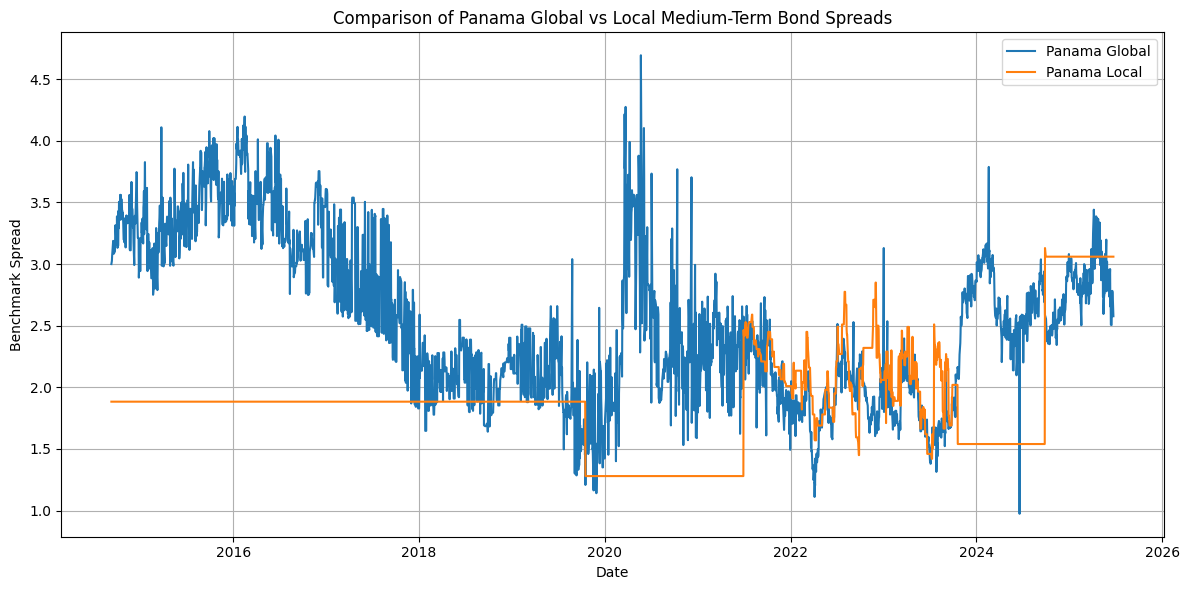

In [70]:
# Step 8.1: Check for missing values
print("Missing values in final dataframe:")
print(final_df.isnull().sum())

# Step 8.2: Basic statistics of the new column
print("\nStatistics for panama_local_medium_term:")
print(final_df['panama_local_medium_term'].describe())

# Step 8.3: Compare with other columns
print("\nComparison between panama_medium_term and panama_local_medium_term:")
print(final_df[['panama_medium_term', 'panama_local_medium_term']].describe())

# Step 8.4: Visualize the comparison
plt.figure(figsize=(12, 6))
plt.plot(final_df['date'], final_df['panama_medium_term'], label='Panama Global')
plt.plot(final_df['date'], final_df['panama_local_medium_term'], label='Panama Local')
plt.title('Comparison of Panama Global vs Local Medium-Term Bond Spreads')
plt.xlabel('Date')
plt.ylabel('Benchmark Spread')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [71]:
# Step 9.1: Update the panama_med_term_med_df_filled with the new column
panama_med_term_med_df_filled = final_df.copy()

# Step 9.2: Optional - Save to CSV
# panama_med_term_med_df_filled.to_csv('panama_med_term_med_df_with_local.csv', index=False)

# Display the final dataframe
panama_med_term_med_df_filled.head()

date  brasil_medium_term  chile_medium_term  colombia_medium_term  \
0 2014-09-09             2.51642           1.232342              2.679124   
1 2014-09-10             2.51642           1.232342              2.679124   
2 2014-09-11             2.51642           1.232342              2.679124   
3 2014-09-12             2.51642           1.232342              2.679124   
4 2014-09-15             2.51642           1.232342              2.679124   

   crc_medium_term  indonesia_medium_term  mexico_medium_term  \
0         3.868548               1.237604               2.743   
1         3.868548               1.237604               2.743   
2         3.868548               1.237604               2.743   
3         3.868548               1.237604               2.743   
4         3.868548               1.237604               2.743   

   peru_medium_term  panama_medium_term  panama  panama_local_medium_term  
0          1.376878               3.000   3.000                   1.88366  
1          1.376878               3.016   3.016                   1.88366  
2          1.376878               3.026   3.026                   1.88366  
3          1.376878               3.069   3.069                   1.88366  
4          1.376878               3.161   3.161                   1.88366

In [72]:
panama_med_term_med_df_filled.tail()

date  brasil_medium_term  chile_medium_term  colombia_medium_term  \
2809 2025-06-17             1.86225           0.940667              3.148333   
2810 2025-06-18             1.86600           0.942000              3.163833   
2811 2025-06-19             1.86600           0.942000              3.163833   
2812 2025-06-20             1.87600           0.952667              3.218333   
2813 2025-06-23             1.89125           0.960667              3.234167   

      crc_medium_term  indonesia_medium_term  mexico_medium_term  \
2809            1.527               0.680571            1.605500   
2810            1.557               0.689857            1.613000   
2811            1.557               0.689857            1.613000   
2812            1.573               0.705143            1.639333   
2813            1.625               0.738286            1.636667   

      peru_medium_term  panama_medium_term    panama  panama_local_medium_term  
2809            1.2548            2.684000  2.684000                      3.06  
2810            1.2652            2.782000  2.782000                      3.06  
2811            1.2652            2.782000  2.782000                      3.06  
2812            1.2856            2.768429  2.768429                      3.06  
2813            1.2992            2.577000  2.577000                      3.06

In [73]:
#path to save the file
path_to_save = "C:/Users/dsosa/Documents/augment-projects/cbonds-comparables/data/processed"

In [74]:
#save the file
panama_med_term_med_df_filled.to_csv(os.path.join(path_to_save, "panama_med_term_med_df_filled.csv"), index=False)

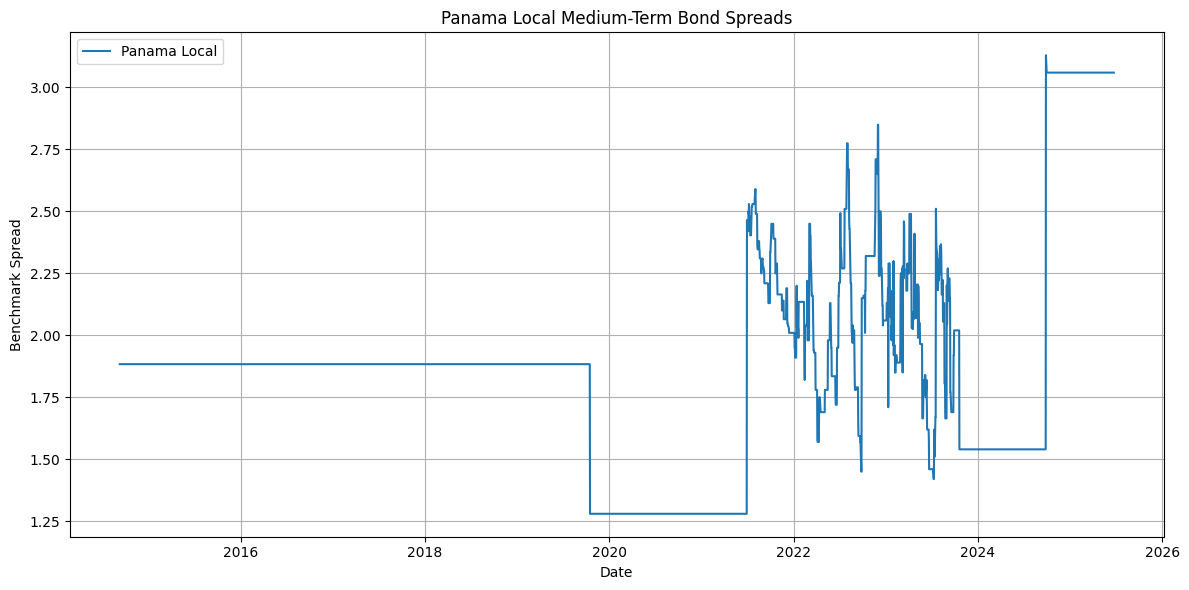

In [75]:
#plot of panama_local_medium_term
plt.figure(figsize=(12, 6))
plt.plot(panama_med_term_med_df_filled['date'], panama_med_term_med_df_filled['panama_local_medium_term'], label='Panama Local')
plt.title('Panama Local Medium-Term Bond Spreads')
plt.xlabel('Date')
plt.ylabel('Benchmark Spread')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Start Model Training

In [76]:
panama_med_term_med_df_filled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2814 entries, 0 to 2813
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   date                      2814 non-null   datetime64[ns]
 1   brasil_medium_term        2814 non-null   float64       
 2   chile_medium_term         2814 non-null   float64       
 3   colombia_medium_term      2814 non-null   float64       
 4   crc_medium_term           2814 non-null   float64       
 5   indonesia_medium_term     2814 non-null   float64       
 6   mexico_medium_term        2814 non-null   float64       
 7   peru_medium_term          2814 non-null   float64       
 8   panama_medium_term        2814 non-null   float64       
 9   panama                    2814 non-null   float64       
 10  panama_local_medium_term  2814 non-null   float64       
dtypes: datetime64[ns](1), float64(10)
memory usage: 242.0 KB


In [77]:
# Base to model
base_to_model_df = panama_med_term_med_df_filled.copy()

In [78]:
#function to analize variance, unique %, and corr
def analyze_column_variance(df, threshold=0.01):
    """
    Analyzes the variance, unique value percentages, and correlations of columns in a DataFrame.

    :param df: Input DataFrame with features to analyze
    :param threshold: Variance threshold for identifying low variance columns (default: 0.01)
    :return: A tuple containing:
             - DataFrame with variance and unique value percentages for each column
             - List of low variance columns
             - List of highly correlated feature pairs

    This function performs the following steps:
    1. Separates the first column (assumed to be a date) from feature columns
    2. Calculates variance for each feature column
    3. Identifies columns with variance below the specified threshold
    4. Computes the percentage of unique values in each column
    5. Calculates the correlation matrix for all features
    6. Identifies pairs of highly correlated features (correlation > 0.95)
    """

    # Separate date column (assumed to be the first column) from features
    date_column = df.iloc[:, 0]
    features = df.iloc[:, 1:]

    # Calculate variance for each feature column
    variances = features.var()

    # Identify columns with variance below the specified threshold
    low_variance_columns = variances[variances < threshold].index.tolist()

    # Calculate the percentage of unique values in each column
    unique_percentages = features.nunique() / len(features) * 100

    # Compute the correlation matrix for all features
    correlation_matrix = features.corr()

    # Find pairs of highly correlated features (correlation > 0.95)
    high_correlation_pairs = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > 0.95:
                high_correlation_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j]))

    # Combine variance and unique value percentage results into a DataFrame
    results = pd.DataFrame({
        'Variance': variances,
        'Unique_Values_Percentage': unique_percentages
    })

    # Return the results DataFrame, low variance columns, and highly correlated feature pairs
    return results, low_variance_columns, high_correlation_pairs

In [79]:
# Apply the function to your dataset
results, low_variance_cols, high_corr_pairs = analyze_column_variance(base_to_model_df)

In [80]:
# Print results
print("Column Analysis Results:")
print(results)
print("\nLow Variance Columns (< 0.01):")
print(low_variance_cols)
print("\nHighly Correlated Pairs (> 0.95):")
for pair in high_corr_pairs:
    print(f"{pair[0]} - {pair[1]}")

Column Analysis Results:
                          Variance  Unique_Values_Percentage
brasil_medium_term        0.213893                 42.999289
chile_medium_term         0.072128                 47.334755
colombia_medium_term      0.364675                 57.889126
crc_medium_term           2.358778                 50.675195
indonesia_medium_term     0.144178                 52.025586
mexico_medium_term        0.377964                 85.429993
peru_medium_term          0.068102                 52.167733
panama_medium_term        0.424355                 83.582090
panama                    0.424355                 83.582090
panama_local_medium_term  0.187864                  6.361052

Low Variance Columns (< 0.01):
[]

Highly Correlated Pairs (> 0.95):
panama - panama_medium_term


In [81]:
# Check if there are any remaining NaNs
base_to_model_df.isna().sum()

date                        0
brasil_medium_term          0
chile_medium_term           0
colombia_medium_term        0
crc_medium_term             0
indonesia_medium_term       0
mexico_medium_term          0
peru_medium_term            0
panama_medium_term          0
panama                      0
panama_local_medium_term    0
dtype: int64

In [82]:
# Select numeric columns, excluding 'year'
numeric_columns = base_to_model_df.select_dtypes(include=[np.number]).columns

In [83]:
#count negative values in base_to_model
base_to_model_df[(base_to_model_df[numeric_columns] < 0)].count()

date                        0
brasil_medium_term          0
chile_medium_term           0
colombia_medium_term        0
crc_medium_term             0
indonesia_medium_term       0
mexico_medium_term          0
peru_medium_term            0
panama_medium_term          0
panama                      0
panama_local_medium_term    0
dtype: int64

# Define Target

In [84]:
#define df
df = base_to_model_df.copy()
print(df.shape)

(2814, 11)


In [85]:
# Create target variables
df['target_1day'] = df['panama'].shift(-1)
#df['target_15day'] = df['panama'].shift(-15)
#df['target_30day'] = df['panama'].shift(-30)

In [86]:
# Create separate DataFrames for each target, dropping NaN values
df_1day = df.dropna(subset=['target_1day'])
#df_15day = df.dropna(subset=['target_15day'])
#df_30day = df.dropna(subset=['target_30day'])

In [87]:
# Display the first few rows of each DataFrame
print("1-day target DataFrame:")
print(df_1day.head())
#print("\n15-day target DataFrame:")
#print(df_15day.head())
#print("\n30-day target DataFrame:")
#print(df_30day.head())

1-day target DataFrame:
        date  brasil_medium_term  chile_medium_term  colombia_medium_term  \
0 2014-09-09             2.51642           1.232342              2.679124   
1 2014-09-10             2.51642           1.232342              2.679124   
2 2014-09-11             2.51642           1.232342              2.679124   
3 2014-09-12             2.51642           1.232342              2.679124   
4 2014-09-15             2.51642           1.232342              2.679124   

   crc_medium_term  indonesia_medium_term  mexico_medium_term  \
0         3.868548               1.237604               2.743   
1         3.868548               1.237604               2.743   
2         3.868548               1.237604               2.743   
3         3.868548               1.237604               2.743   
4         3.868548               1.237604               2.743   

   peru_medium_term  panama_medium_term  panama  panama_local_medium_term  \
0          1.376878               3.000   3.0

In [88]:
# Display the shapes of the DataFrames
print("\nDataFrame shapes:")
print(f"Original: {df.shape}")
print(f"1-day target: {df_1day.shape}")
#print(f"15-day target: {df_15day.shape}")
#print(f"30-day target: {df_30day.shape}")


DataFrame shapes:
Original: (2814, 12)
1-day target: (2813, 12)


In [89]:
#min max date
print(df['date'].min())
print(df['date'].max())

2014-09-09 00:00:00
2025-06-23 00:00:00


In [90]:
#base to use
df = df_1day.copy() #>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> this target is used here!!
#df = df_15day.copy() 
#df = df_30day.copy()
print(df.shape)

(2813, 12)


In [91]:
# Option 1: Reset index and drop the old index
df = df.reset_index(drop=True)

In [92]:
df.head()

date  brasil_medium_term  chile_medium_term  colombia_medium_term  \
0 2014-09-09             2.51642           1.232342              2.679124   
1 2014-09-10             2.51642           1.232342              2.679124   
2 2014-09-11             2.51642           1.232342              2.679124   
3 2014-09-12             2.51642           1.232342              2.679124   
4 2014-09-15             2.51642           1.232342              2.679124   

   crc_medium_term  indonesia_medium_term  mexico_medium_term  \
0         3.868548               1.237604               2.743   
1         3.868548               1.237604               2.743   
2         3.868548               1.237604               2.743   
3         3.868548               1.237604               2.743   
4         3.868548               1.237604               2.743   

   peru_medium_term  panama_medium_term  panama  panama_local_medium_term  \
0          1.376878               3.000   3.000                   1.88366   
1          1.376878               3.016   3.016                   1.88366   
2          1.376878               3.026   3.026                   1.88366   
3          1.376878               3.069   3.069                   1.88366   
4          1.376878               3.161   3.161                   1.88366   

   target_1day  
0        3.016  
1        3.026  
2        3.069  
3        3.161  
4        3.188

# Features Engineering

In [93]:
def feature_engineering(df, target_columns=['panama','panama_medium_term', 'target_1day'], 
                        lags=[1, 3, 7], rolling_windows=[3, 7, 15, 30, 60, 90]):
    df = df.copy()
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values('date').reset_index(drop=True)

    comparable_columns = [col for col in df.columns if col not in ['date'] + target_columns]

    new_features = {}
    
    # Safe division function to prevent infinity
    def safe_divide(a, b, fill_value=0):
        # Convert inputs to numpy arrays if they aren't already
        if isinstance(a, (pd.Series, pd.DataFrame)):
            a = a.values
        if isinstance(b, (pd.Series, pd.DataFrame)):
            b = b.values
            
        result = np.zeros_like(a, dtype=float)
        mask = b != 0
        result[mask] = a[mask] / b[mask]
        result[~mask] = fill_value
        return result

    # ===== EXISTING FEATURES =====
    
    # Lag features
    for col in comparable_columns:
        for lag in lags:
            new_features[f'{col}_lag_{lag}'] = df[col].shift(lag)

    # Rolling statistics
    for col in comparable_columns:
        for window in rolling_windows:
            new_features[f'{col}_rolling_mean_{window}'] = df[col].rolling(window=window, min_periods=1).mean()
            new_features[f'{col}_rolling_std_{window}'] = df[col].rolling(window=window, min_periods=1).std().fillna(0)

    # Cross-sectional features
    new_features['cross_sectional_mean'] = df[comparable_columns].mean(axis=1)
    new_features['cross_sectional_std'] = df[comparable_columns].std(axis=1)

    # Relative features
    for col in comparable_columns:
        # Use safe division and convert result to Series
        new_features[f'{col}_relative_to_mean'] = pd.Series(
            safe_divide(df[col].values, new_features['cross_sectional_mean'].values),
            index=df.index
        )

    # Momentum features
    for col in comparable_columns:
        for window in rolling_windows:
            # Use pct_change with fill method
            pct_change = df[col].pct_change(periods=window).fillna(0)
            # Clip extreme values
            new_features[f'{col}_momentum_{window}'] = np.clip(pct_change, -10, 10)

    # Non-linear transformations
    for i, col1 in enumerate(comparable_columns):
        for col2 in comparable_columns[i+1:]:
            new_features[f'{col1}_x_{col2}'] = df[col1] * df[col2]

    # Date-based features
    new_features['day_of_week'] = df['date'].dt.dayofweek
    new_features['month'] = df['date'].dt.month
    new_features['quarter'] = df['date'].dt.quarter
    new_features['year'] = df['date'].dt.year
    new_features['days_since_start'] = (df['date'] - df['date'].min()).dt.days

    # Lagged differences
    for col in comparable_columns:
        for lag in lags:
            new_features[f'{col}_diff_{lag}'] = df[col].diff(lag).fillna(0)

    # Rolling correlations
    for col1 in comparable_columns:
        for col2 in comparable_columns:
            if col1 != col2:
                for window in rolling_windows:
                    # Use min_periods to avoid NaN with small windows
                    corr = df[col1].rolling(window, min_periods=2).corr(df[col2])
                    new_features[f'{col1}_{col2}_corr_{window}'] = corr.fillna(0)

    # Panama-specific features
    for lag in [1, 3]:
        new_features[f'panama_lag_{lag}'] = df['panama'].shift(lag).fillna(method='bfill')

    # Relative features for panama
    short_term_columns = [col for col in comparable_columns if 'medium_term' in col]
    for col in short_term_columns:
        # Use safe division and convert to Series
        new_features[f'panama_relative_to_{col}'] = pd.Series(
            safe_divide(df['panama'].values, df[col].values),
            index=df.index
        )
    
    # ===== NEW LOCAL-GLOBAL RELATIONSHIP FEATURES =====
    
    if 'panama_local_medium_term' in df.columns and 'panama' in df.columns:
        # 1. Spread Differential: local_global_diff
        new_features['local_global_diff'] = df['panama_local_medium_term'] - df['panama']
        
        # Lagged differentials
        for lag in lags:
            new_features[f'local_global_diff_lag_{lag}'] = new_features['local_global_diff'].shift(lag).fillna(0)
        
        # Changes in differential
        for lag in lags:
            new_features[f'local_global_diff_change_{lag}'] = new_features['local_global_diff'].diff(lag).fillna(0)
        
        # 2. Spread Ratio: local_global_ratio (using safe division)
        new_features['local_global_ratio'] = pd.Series(
            safe_divide(df['panama_local_medium_term'].values, df['panama'].values),
            index=df.index
        )
        
        # Lagged ratios
        for lag in lags:
            new_features[f'local_global_ratio_lag_{lag}'] = new_features['local_global_ratio'].shift(lag).fillna(1)
        
        # Changes in ratio (using safe pct_change)
        for lag in lags:
            ratio_change = new_features['local_global_ratio'].pct_change(periods=lag).fillna(0)
            new_features[f'local_global_ratio_change_{lag}'] = np.clip(ratio_change, -10, 10)
        
        # 3. Z-score of Differential
        # Calculate rolling mean and std for the differential
        for window in rolling_windows:
            diff_mean = new_features['local_global_diff'].rolling(window=window, min_periods=1).mean()
            diff_std = new_features['local_global_diff'].rolling(window=window, min_periods=1).std()
            # Avoid division by zero
            diff_std = diff_std.replace(0, 1)
            z_scores = (new_features['local_global_diff'] - diff_mean) / diff_std
            new_features[f'local_global_diff_zscore_{window}'] = np.clip(z_scores, -10, 10).fillna(0)
        
        # 4. Rolling Correlation between local and global spreads
        for window in [30, 60, 90]:  # Specific windows for this analysis
            # Use min_periods to avoid NaN with small windows
            corr = df['panama_local_medium_term'].rolling(window, min_periods=2).corr(df['panama'])
            new_features[f'local_global_corr_{window}'] = corr.fillna(0)
        
        # Changes in correlation (can signal regime shifts)
        for window in [30, 60, 90]:
            if f'local_global_corr_{window}' in new_features:
                corr_change = new_features[f'local_global_corr_{window}'].diff(1).fillna(0)
                new_features[f'local_global_corr_change_{window}'] = corr_change
        
        # 5. Additional derived features
        
        # Volatility ratio (local volatility / global volatility)
        for window in rolling_windows:
            local_vol = df['panama_local_medium_term'].rolling(window, min_periods=1).std().fillna(0.0001)
            global_vol = df['panama'].rolling(window, min_periods=1).std().fillna(0.0001)
            # Convert to Series after safe division
            vol_ratio = pd.Series(
                safe_divide(local_vol.values, global_vol.values, fill_value=1),
                index=df.index
            )
            new_features[f'local_global_vol_ratio_{window}'] = np.clip(vol_ratio, 0.01, 100)
        
        # Divergence indicator (binary feature for when local-global spread exceeds historical thresholds)
        for window in rolling_windows:
            diff_mean = new_features['local_global_diff'].rolling(window=window, min_periods=1).mean()
            diff_std = new_features['local_global_diff'].rolling(window=window, min_periods=1).std().fillna(0.0001)
            
            # Create binary indicators for significant divergences (>1.5 std, >2 std)
            threshold_1_5 = ((new_features['local_global_diff'] - diff_mean).abs() > (1.5 * diff_std))
            threshold_2_0 = ((new_features['local_global_diff'] - diff_mean).abs() > (2.0 * diff_std))
            
            new_features[f'local_global_divergence_1.5std_{window}'] = threshold_1_5.astype(int)
            new_features[f'local_global_divergence_2std_{window}'] = threshold_2_0.astype(int)
        
        # Trend alignment (are local and global spreads moving in the same direction?)
        for window in rolling_windows:
            # Use np.sign to determine direction (-1, 0, or 1)
            local_trend = np.sign(df['panama_local_medium_term'].diff(window).fillna(0))
            global_trend = np.sign(df['panama'].diff(window).fillna(0))
            new_features[f'trend_alignment_{window}'] = (local_trend == global_trend).astype(int)
    
    # Combine all features at once
    result_df = pd.concat([df, pd.DataFrame(new_features)], axis=1)
    
    # Replace infinities with NaN
    result_df = result_df.replace([np.inf, -np.inf], np.nan)
    
    # Handle NaN values
    result_df = result_df.ffill().bfill()
    
    # Clip extreme values
    for col in result_df.columns:
        if result_df[col].dtype in [np.float64, np.float32, np.int64, np.int32]:
            col_mean = result_df[col].mean()
            col_std = result_df[col].std()
            if not pd.isna(col_std) and col_std > 0:
                lower_bound = col_mean - 5 * col_std
                upper_bound = col_mean + 5 * col_std
                result_df[col] = result_df[col].clip(lower=lower_bound, upper=upper_bound)
    
    return result_df

# Split Data

In [94]:
initial_train_dataset = df[(df['date'] >= '2016-02-01') & (df['date'] <= '2024-04-29')]
initial_validation_dataset = df[(df['date'] > '2024-04-29') & (df['date'] < '2025-01-30')]
non_seen_test_data = df[(df['date'] >= '2025-01-30')]

##print shapes
print('train data  ------>', initial_train_dataset.shape)
print('validation data  ------>', initial_validation_dataset.shape)
print('Non-seen data  ------>', non_seen_test_data.shape)

train data  ------> (2151, 12)
validation data  ------> (196, 12)
Non-seen data  ------> (102, 12)


In [95]:
#check NaN or infinite
print(initial_train_dataset.isna().sum())
print(initial_validation_dataset.isna().sum())
print(non_seen_test_data.isna().sum())

date                        0
brasil_medium_term          0
chile_medium_term           0
colombia_medium_term        0
crc_medium_term             0
indonesia_medium_term       0
mexico_medium_term          0
peru_medium_term            0
panama_medium_term          0
panama                      0
panama_local_medium_term    0
target_1day                 0
dtype: int64
date                        0
brasil_medium_term          0
chile_medium_term           0
colombia_medium_term        0
crc_medium_term             0
indonesia_medium_term       0
mexico_medium_term          0
peru_medium_term            0
panama_medium_term          0
panama                      0
panama_local_medium_term    0
target_1day                 0
dtype: int64
date                        0
brasil_medium_term          0
chile_medium_term           0
colombia_medium_term        0
crc_medium_term             0
indonesia_medium_term       0
mexico_medium_term          0
peru_medium_term            0
panama_medium_

In [96]:
#add create_features functions to sets
initial_train_dataset = feature_engineering(initial_train_dataset)
initial_validation_dataset = feature_engineering(initial_validation_dataset)
non_seen_test_data = feature_engineering(non_seen_test_data)

C:\Users\dsosa\AppData\Local\Temp\ipykernel_9188\3081945255.py:86: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  new_features[f'panama_lag_{lag}'] = df['panama'].shift(lag).fillna(method='bfill')
C:\Users\dsosa\AppData\Local\Temp\ipykernel_9188\3081945255.py:86: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  new_features[f'panama_lag_{lag}'] = df['panama'].shift(lag).fillna(method='bfill')
C:\Users\dsosa\AppData\Local\Temp\ipykernel_9188\3081945255.py:86: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  new_features[f'panama_lag_{lag}'] = df['panama'].shift(lag).fillna(method='bfill')


In [97]:
#define final_train_set
final_train_set = initial_train_dataset.copy()
print(final_train_set.shape)

(2151, 643)


# Voting System

In [98]:
#define train_set
train_set = final_train_set.copy()
print(train_set.shape)

(2151, 643)


In [99]:
# Number of samples should match the number of rows in your dataset
data_size = train_set.shape[0]

In [100]:
# Set the random seed for reproducibility
np.random.seed(42)  # Using a different seed

# Generate a wider variety of noise features
# Gaussian noise with different means and standard deviations
noise_gaussian_1 = np.random.normal(loc=0, scale=1, size=data_size)
noise_gaussian_2 = np.random.normal(loc=0, scale=2, size=data_size)
noise_gaussian_3 = np.random.normal(loc=0, scale=3, size=data_size)
noise_gaussian_4 = np.random.normal(loc=5, scale=1, size=data_size)  # Different mean

# Uniform noise with different ranges
noise_uniform_1 = np.random.uniform(low=-1, high=1, size=data_size)
noise_uniform_2 = np.random.uniform(low=0, high=10, size=data_size)
noise_uniform_3 = np.random.uniform(low=-5, high=5, size=data_size)
noise_uniform_4 = np.random.uniform(low=-10, high=10, size=data_size)  # Wider range

# Poisson noise with different lambda values
lambda_value = 3
poisson_noise_1 = np.random.poisson(lam=lambda_value, size=data_size)
poisson_noise_2 = np.random.poisson(lam=lambda_value * 2, size=data_size)
poisson_noise_3 = np.random.poisson(lam=lambda_value * 3, size=data_size)

# Add more complex noise types
# Random walk (cumulative sum of random steps)
random_walk = np.cumsum(np.random.normal(0, 1, data_size))

# Sinusoidal noise (periodic pattern)
x = np.linspace(0, 10, data_size)
sinusoidal_noise = np.sin(x) + np.random.normal(0, 0.1, data_size)

# Add the noise variables to the final_train_set DataFrame
train_set['Gaussian_Noise_Std1'] = noise_gaussian_1
train_set['Gaussian_Noise_Std2'] = noise_gaussian_2
train_set['Gaussian_Noise_Mean5'] = noise_gaussian_4
train_set['Uniform_Noise_Range1'] = noise_uniform_1
train_set['Uniform_Noise_Range10'] = noise_uniform_4
train_set['Poisson_Noise_Lambda3'] = poisson_noise_1
train_set['RandomWalk_Noise'] = random_walk
train_set['Sinusoidal_Noise'] = sinusoidal_noise

# Create a list of all noise feature names for later use
noise_features = ['Gaussian_Noise_Std1', 'Gaussian_Noise_Std2', 'Gaussian_Noise_Mean5', 
                 'Uniform_Noise_Range1', 'Uniform_Noise_Range10', 'Poisson_Noise_Lambda3',
                 'RandomWalk_Noise', 'Sinusoidal_Noise']

In [101]:
# Define the features (X) and target variable (y)
X = train_set.drop(['panama', 'panama_medium_term', 'target_1day','date'], axis=1)
y = train_set['target_1day']

In [102]:
# Replace classification models with regression models
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
import lightgbm as lgb

In [103]:
# Initialize regression models instead of classification models
model1 = RandomForestRegressor(random_state=42)
model2 = lgb.LGBMRegressor(random_state=42)
model3 = Ridge(random_state=42)

In [104]:
# Fit the models
model1.fit(X, y)
model2.fit(X, y)
model3.fit(X, y)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029685 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 153166
[LightGBM] [Info] Number of data points in the train set: 2151, number of used features: 645
[LightGBM] [Info] Start training from score 2.358078


Ridge(random_state=42)

In [105]:
# Get feature importances or coefficients
importances1 = model1.feature_importances_
importances2 = model2.feature_importances_
importances3 = model3.coef_  # This will be a 1D array for Ridge

In [106]:
# Set the desired number of top features to select
top_n_features = 40

In [107]:
#import 
from sklearn.feature_selection import SelectFromModel

In [108]:
# Select top features using feature importances or coefficients
selector1 = SelectFromModel(model1, prefit=True, max_features=top_n_features)
selector2 = SelectFromModel(model2, prefit=True, max_features=top_n_features)
selector3 = SelectFromModel(model3, prefit=True, max_features=top_n_features)

In [109]:
# Get the selected features
selected_features1 = selector1.get_support()
selected_features2 = selector2.get_support()
selected_features3 = selector3.get_support()

In [110]:
# Count the votes for each feature
feature_votes = selected_features1.astype(int) + selected_features2.astype(int) + selected_features3.astype(int)

In [111]:
# Set a threshold for the minimum number of votes required
vote_threshold = 1
selected_features = feature_votes >= vote_threshold

In [112]:
# Get the selected feature names
selected_features_names = X.columns[selected_features]

In [113]:
#display more rows
pd.set_option('display.max_rows', 200)

In [114]:
# Get feature importances as a DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'RF_Importance': importances1,
    'LGBM_Importance': importances2,
    'Ridge_Importance': np.abs(importances3[0]),
    'Votes': feature_votes
})

# Add a column indicating if the feature is a noise feature
feature_importance_df['Is_Noise'] = feature_importance_df['Feature'].isin(noise_features)

# Sort by votes (descending) and then by average importance (descending)
feature_importance_df['Avg_Importance'] = feature_importance_df[['RF_Importance', 'LGBM_Importance', 'Ridge_Importance']].mean(axis=1)
feature_importance_df = feature_importance_df.sort_values(['Votes', 'Avg_Importance'], ascending=False)

# Print the ranking table
print("Feature Ranking (with Noise Features highlighted):")
print(feature_importance_df[['Feature', 'Votes', 'Avg_Importance', 'Is_Noise']])

# Calculate how many real features outperform the best noise feature
best_noise_rank = feature_importance_df[feature_importance_df['Is_Noise']].index.min()
features_better_than_noise = len(feature_importance_df.loc[:best_noise_rank-1])
print(f"\nNumber of features outperforming the best noise feature: {features_better_than_noise}")

# Select features that outperform the best noise feature
selected_features_above_noise = feature_importance_df.iloc[:best_noise_rank]['Feature'].tolist()
print("\nSelected features (outperforming noise):")
print(selected_features_above_noise)

Feature Ranking (with Noise Features highlighted):
                                               Feature  Votes  Avg_Importance  \
600                        local_global_ratio_change_1      3       16.009451   
589                                  local_global_diff      3       13.690116   
172                     mexico_medium_term_momentum_60      3       12.009209   
581              panama_relative_to_brasil_medium_term      3        9.345258   
593                         local_global_diff_change_1      2       22.343862   
..                                                 ...    ...             ...   
240                    panama_local_medium_term_diff_1      0        0.008659   
321  chile_medium_term_panama_local_medium_term_corr_3      0        0.008659   
540  panama_local_medium_term_brasil_medium_term_co...      0        0.008659   
622                     local_global_divergence_2std_3      0        0.008658   
621                   local_global_divergence_1.5std_3    

In [115]:
# Get all noise features and their ranks
noise_ranks = [feature_importance_df.index.get_loc(i) 
               for i in feature_importance_df.index 
               if feature_importance_df.loc[i, 'Is_Noise']]

if noise_ranks:  # Check if we found any noise features
    # Get the median rank of noise features
    median_noise_rank = int(np.median(noise_ranks))
    print(f"Median rank of noise features: {median_noise_rank}")

    # Select features above the median noise rank
    features_above_median_noise = feature_importance_df.iloc[:median_noise_rank]['Feature'].tolist()
    print(f"\nFeatures above median noise rank: {len(features_above_median_noise)}")
    print(features_above_median_noise)

    # Get importance scores of noise features
    noise_importances = feature_importance_df[feature_importance_df['Is_Noise']]['Avg_Importance'].values

    # Calculate mean and standard deviation of noise importances
    noise_mean = np.mean(noise_importances)
    noise_std = np.std(noise_importances)

    # Set threshold as just the mean of noise importances (more lenient)
    statistical_threshold = noise_mean
    print(f"Statistical threshold based on noise distribution: {statistical_threshold}")

    # Select features above this threshold
    features_above_threshold = feature_importance_df[feature_importance_df['Avg_Importance'] > statistical_threshold]['Feature'].tolist()
    print(f"\nFeatures above statistical threshold: {len(features_above_threshold)}")
    print(features_above_threshold)

    # Create a set of all features from all three approaches
    features_above_first_noise = set(selected_features_above_noise)
    features_above_median_noise = set(features_above_median_noise)
    features_above_threshold = set(features_above_threshold)
    
    # Collect all unique features from all three approaches
    all_features = set()
    all_features.update(features_above_first_noise)
    all_features.update(features_above_median_noise)
    all_features.update(features_above_threshold)
    
    # Features that pass at least 2 out of 3 noise-based filters
    robust_features = []
    for feature in all_features:
        passes = 0
        if feature in features_above_first_noise: passes += 1
        if feature in features_above_median_noise: passes += 1
        if feature in features_above_threshold: passes += 1
        if passes >= 2:  # Only require 2 out of 3 passes
            robust_features.append(feature)
    
    print(f"\nRobust features (pass at least 2 out of 3 filters): {len(robust_features)}")
    print(robust_features)
    
    # Set the final selected features to the robust set
    selected_features_final = robust_features
else:
    print("No noise features found in the top features. Using the vote threshold approach.")
    selected_features_final = selected_features_names

Median rank of noise features: 12

Features above median noise rank: 12
['local_global_ratio_change_1', 'local_global_diff', 'mexico_medium_term_momentum_60', 'panama_relative_to_brasil_medium_term', 'local_global_diff_change_1', 'panama_lag_3', 'mexico_medium_term_diff_1', 'panama_lag_1', 'Gaussian_Noise_Mean5', 'Gaussian_Noise_Std1', 'RandomWalk_Noise', 'Gaussian_Noise_Std2']
Statistical threshold based on noise distribution: 14.092550305959634

Features above statistical threshold: 13
['local_global_ratio_change_1', 'local_global_diff_change_1', 'panama_lag_3', 'mexico_medium_term_diff_1', 'panama_lag_1', 'Gaussian_Noise_Mean5', 'Gaussian_Noise_Std1', 'RandomWalk_Noise', 'Gaussian_Noise_Std2', 'local_global_diff_zscore_3', 'mexico_medium_term_rolling_std_3', 'mexico_medium_term_rolling_std_7', 'local_global_diff_change_3']

Robust features (pass at least 2 out of 3 filters): 16
['local_global_diff_change_1', 'mexico_medium_term_rolling_std_7', 'local_global_diff_zscore_3', 'RandomWa

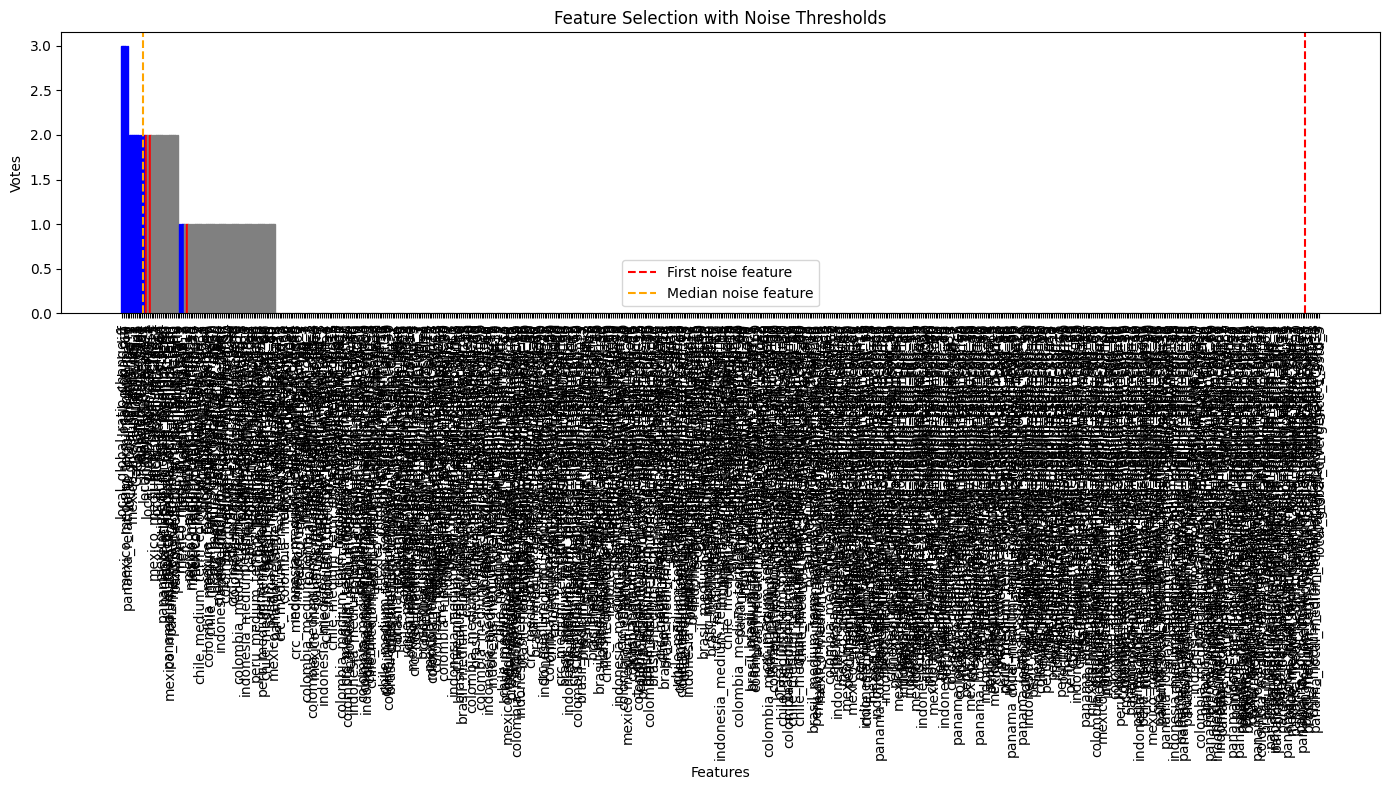

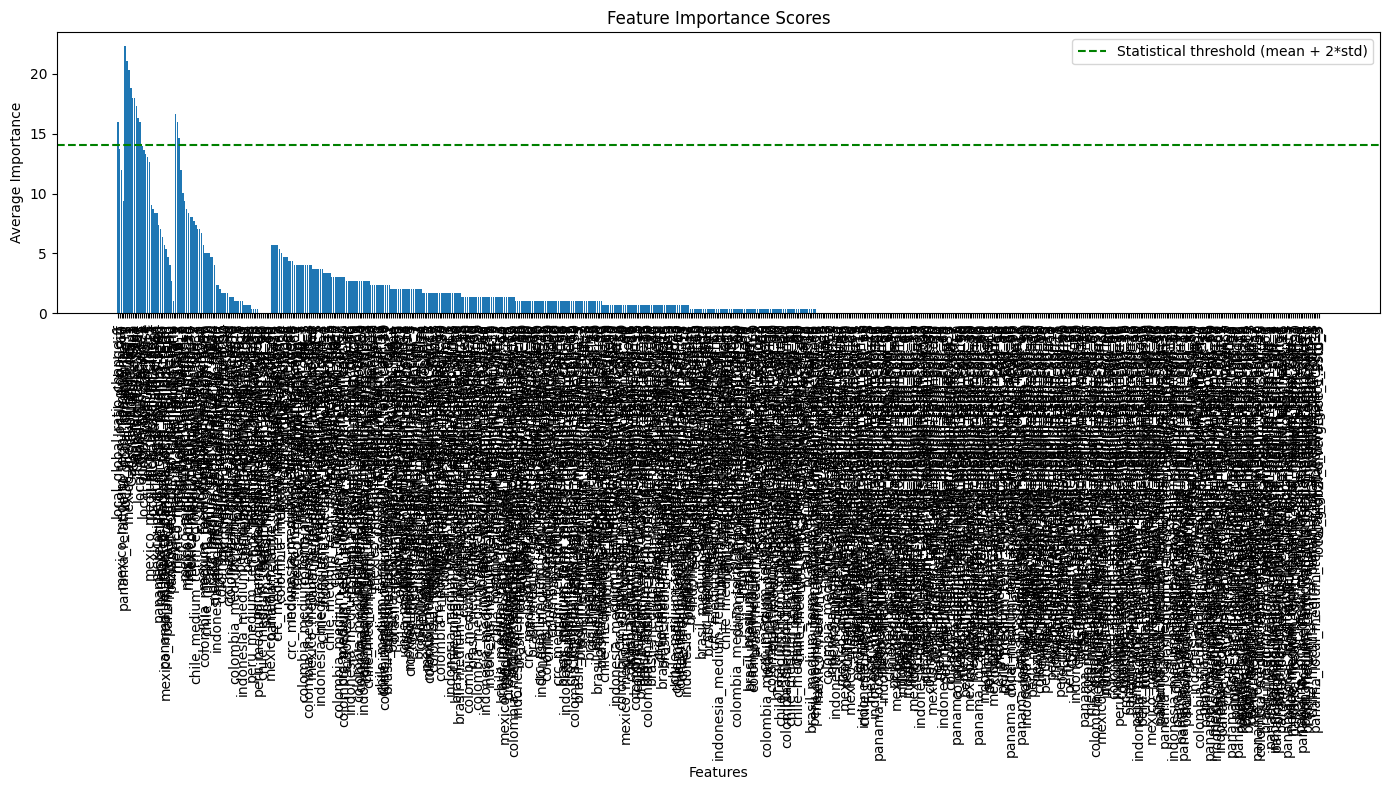

In [116]:
# Create a visualization of feature importance with noise threshold
plt.figure(figsize=(14, 8))
bars = plt.bar(range(len(feature_importance_df)), feature_importance_df['Votes'])

# Color the bars: blue for selected features, red for noise, gray for others
for i, (idx, row) in enumerate(feature_importance_df.iterrows()):
    if row['Feature'] in selected_features_final:  # Selected features
        bars[i].set_color('blue')
    elif row['Is_Noise']:  # Noise features
        bars[i].set_color('red')
    else:  # Features below noise
        bars[i].set_color('gray')

# Add vertical lines for different thresholds
if noise_ranks:
    plt.axvline(x=best_noise_rank-0.5, color='red', linestyle='--', 
                label='First noise feature')
    plt.axvline(x=median_noise_rank-0.5, color='orange', linestyle='--', 
                label='Median noise feature')

plt.xticks(range(len(feature_importance_df)), feature_importance_df['Feature'], rotation='vertical')
plt.xlabel('Features')
plt.ylabel('Votes')
plt.title('Feature Selection with Noise Thresholds')
plt.legend()
plt.tight_layout()
plt.show()

# Create a more detailed visualization of feature importance scores
plt.figure(figsize=(14, 8))
plt.bar(range(len(feature_importance_df)), feature_importance_df['Avg_Importance'])
plt.xticks(range(len(feature_importance_df)), feature_importance_df['Feature'], rotation='vertical')

# Add a horizontal line for the statistical threshold
if noise_ranks:
    plt.axhline(y=statistical_threshold, color='green', linestyle='--', 
                label=f'Statistical threshold (mean + 2*std)')

plt.xlabel('Features')
plt.ylabel('Average Importance')
plt.title('Feature Importance Scores')
plt.legend()
plt.tight_layout()
plt.show()

In [117]:
# Use the final selected features for your model
print(f"\nFinal selected features: {len(selected_features_final)}")
print(selected_features_final)

# Remove any noise features that might have been included
selected_features_final = [f for f in selected_features_final if f not in noise_features]

# These are the features you'll use for your final model
print(f"\nFinal selected features (excluding noise): {len(selected_features_final)}")
print(selected_features_final)


Final selected features: 16
['local_global_diff_change_1', 'mexico_medium_term_rolling_std_7', 'local_global_diff_zscore_3', 'RandomWalk_Noise', 'mexico_medium_term_rolling_std_3', 'local_global_ratio_change_1', 'mexico_medium_term_diff_1', 'Gaussian_Noise_Std1', 'Gaussian_Noise_Std2', 'Gaussian_Noise_Mean5', 'panama_lag_1', 'panama_lag_3', 'panama_relative_to_brasil_medium_term', 'local_global_diff', 'mexico_medium_term_momentum_60', 'local_global_diff_change_3']

Final selected features (excluding noise): 12
['local_global_diff_change_1', 'mexico_medium_term_rolling_std_7', 'local_global_diff_zscore_3', 'mexico_medium_term_rolling_std_3', 'local_global_ratio_change_1', 'mexico_medium_term_diff_1', 'panama_lag_1', 'panama_lag_3', 'panama_relative_to_brasil_medium_term', 'local_global_diff', 'mexico_medium_term_momentum_60', 'local_global_diff_change_3']


In [171]:
#final features to model if votantes is enough
selected_features = selected_features_final
#print final features
print(selected_features)

['local_global_diff_change_1', 'mexico_medium_term_rolling_std_7', 'local_global_diff_zscore_3', 'mexico_medium_term_rolling_std_3', 'local_global_ratio_change_1', 'mexico_medium_term_diff_1', 'panama_lag_1', 'panama_lag_3', 'panama_relative_to_brasil_medium_term', 'local_global_diff', 'mexico_medium_term_momentum_60', 'local_global_diff_change_3']


In [ ]:
#select target in every set 1d
target_to_use_train = initial_train_dataset.target_1day
target_to_use_validation = initial_validation_dataset.target_1day
target_to_use_test = non_seen_test_data.target_1day

In [121]:
#Model configuration
Y_train_cv, X_train_cv = target_to_use_train, initial_train_dataset
Y_validation, X_validation = target_to_use_validation, initial_validation_dataset
Y_test, X_test = target_to_use_test, non_seen_test_data

In [122]:
# Extract hour and month from datetime
X_train_cv['year'] = pd.to_datetime(X_train_cv['date']).dt.year
X_train_cv['month'] = pd.to_datetime(X_train_cv['date']).dt.month
X_validation['year'] = pd.to_datetime(X_validation['date']).dt.year
X_validation['month'] = pd.to_datetime(X_validation['date']).dt.month

In [123]:
hot_years = [2021,2022,2023]  # Example hot months; adjust as needed

In [124]:
X_train_cv['group'] = X_train_cv.apply(lambda x: x['year'] if x['year'] in hot_years else -1, axis=1)
X_validation['group'] = X_validation.apply(lambda x: x['year'] if x['year'] in hot_years else -1, axis=1)

C:\Users\dsosa\AppData\Local\Temp\ipykernel_9188\3972557615.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train_cv['group'] = X_train_cv.apply(lambda x: x['year'] if x['year'] in hot_years else -1, axis=1)
C:\Users\dsosa\AppData\Local\Temp\ipykernel_9188\3972557615.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_validation['group'] = X_validation.apply(lambda x: x['year'] if x['year'] in hot_years else -1, axis=1)


In [125]:
X_train_cv.group.value_counts()

group
-1       1370
 2021     261
 2022     260
 2023     260
Name: count, dtype: int64

In [126]:
groups_train = X_train_cv['group']
groups_val = X_validation['group']

In [127]:
from sklearn.model_selection import GroupKFold, RandomizedSearchCV, cross_val_score
gkf = GroupKFold(n_splits=4)

In [128]:
final_features_columns = selected_features_names_0

In [129]:
X_train_cv_final = X_train_cv[list(final_features_columns)]
X_validation_final = X_validation[list(final_features_columns)]

In [130]:
print(X_train_cv_final.shape)
print(X_validation_final.shape)

(2151, 12)
(196, 12)


In [131]:
X_train_cv_final.head()

local_global_diff_change_1  mexico_medium_term_rolling_std_7  \
0                      0.0000                          0.000000   
1                     -0.0760                          0.077075   
2                      0.0000                          0.060008   
3                     -0.2085                          0.048999   
4                      0.2015                          0.042459   

   local_global_diff_zscore_3  mexico_medium_term_rolling_std_3  \
0                    0.000000                          0.000000   
1                   -0.707107                          0.077075   
2                   -0.577350                          0.060008   
3                   -1.154701                          0.021221   
4                    0.547539                          0.016289   

   local_global_ratio_change_1  mexico_medium_term_diff_1  panama_lag_1  \
0                     0.000000                      0.000        3.7310   
1                    -0.019963                      0.109        3.7310   
2                     0.000000                     -0.011        3.8070   
3                    -0.051924                     -0.030        3.8070   
4                     0.052832                      0.004        4.0155   

   panama_lag_3  panama_relative_to_brasil_medium_term  local_global_diff  \
0         3.731                               1.482662           -1.84734   
1         3.731                               1.512864           -1.92334   
2         3.731                               1.512864           -1.92334   
3         3.731                               1.595719           -2.13184   
4         3.807                               1.515645           -1.93034   

   mexico_medium_term_momentum_60  local_global_diff_change_3  
0                             0.0                      0.0000  
1                             0.0                      0.0000  
2                             0.0                      0.0000  
3                             0.0                     -0.2845  
4                             0.0                     -0.0070

In [132]:
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV, cross_val_score
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, make_scorer, r2_score
import numpy as np

In [133]:
# Initialize a LGBMRegressor
reg = lgb.LGBMRegressor(random_state=314)

# Set up possible parameters to randomly sample from
param_test = {
'learning_rate': [0.2,0.5,0.8],
    'n_estimators': sp_randint(200, 800),
    'max_depth': sp_randint(4, 8),
    'num_leaves': sp_randint(5, 31),
    'min_child_samples': sp_randint(10, 50),
    'min_child_weight': [0.001, 0.01, 0.1],
    'subsample': sp_uniform(loc=0.6, scale=0.4),
    'colsample_bytree': sp_uniform(loc=0.6, scale=0.4),
    'reg_alpha': [0],
    'reg_lambda': [0],
    'min_split_gain': [0],
    'boosting_type': ['gbdt', 'dart'],
    'force_col_wise': [True],
    'max_bin': sp_randint(200, 300),
    'use_missing': [True, False],
    'zero_as_missing': [True, False]
}

# A dictionary of the metrics of interest for regression
scoring = {
    'neg_mean_squared_error': make_scorer(mean_squared_error, greater_is_better=False),
    'r2': make_scorer(r2_score)
}

# Create the GroupKFold object
gkf = GroupKFold(n_splits=4)

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(reg, param_distributions=param_test,
                                   n_iter=80, scoring=scoring,
                                   cv=gkf.split(X_train_cv_final, Y_train_cv, groups=groups_train),
                                   refit='neg_mean_squared_error',
                                   random_state=314, verbose=1)

# Fit randomized_search
random_search.fit(X_train_cv_final, Y_train_cv,
                  eval_set=[(X_validation_final, Y_validation)],
                  eval_metric='mse',
                  groups=groups_train)

# Get the best parameters from the RandomizedSearchCV and print
best_params = random_search.best_params_
print("Best parameters found: ", best_params)

# Create a new regressor using the best parameters from the RandomizedSearchCV
reg_best = lgb.LGBMRegressor(**best_params, random_state=314)

# Nested CV with parameter optimization using GroupKFold
outer_cv = GroupKFold(n_splits=4)
nested_score = cross_val_score(reg_best, X=X_train_cv_final, y=Y_train_cv,
                               groups=groups_train, cv=outer_cv, scoring='neg_mean_squared_error')
print("Nested CV score (RMSE): ", np.sqrt(-nested_score).mean())

# Train a new model on the whole training set using the best parameters found
reg_best.fit(X_train_cv_final, Y_train_cv,
             eval_set=[(X_validation_final, Y_validation)],
             eval_metric='mse')

# Test the trained model on the unseen test set
predictions = reg_best.predict(X_validation_final)
mse = mean_squared_error(Y_validation, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(Y_validation, predictions)

print(f"Validation RMSE: {rmse}")
print(f"Validation R2: {r2}")

Fitting 4 folds for each of 80 candidates, totalling 320 fits
[LightGBM] [Info] Total Bins 2904
[LightGBM] [Info] Number of data points in the train set: 781, number of used features: 12
[LightGBM] [Info] Start training from score 2.035430
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

In [134]:
#print best model parameters
print(best_params)

{'boosting_type': 'dart', 'colsample_bytree': np.float64(0.9538424581137495), 'force_col_wise': True, 'learning_rate': 0.2, 'max_bin': 294, 'max_depth': 6, 'min_child_samples': 43, 'min_child_weight': 0.1, 'min_split_gain': 0, 'n_estimators': 636, 'num_leaves': 7, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': np.float64(0.6906875722436032), 'use_missing': False, 'zero_as_missing': True}


In [135]:
from sklearn.inspection import permutation_importance

In [136]:
#impute with mean
non_seen_test_data.fillna(non_seen_test_data.mean(), inplace=True)

In [137]:
# Calculate permutation importance
perm_importance = permutation_importance(reg_best, non_seen_test_data[final_features_columns],target_to_use_test, n_repeats=15, random_state=42)

In [138]:
# Sort features by importance
feature_importance = perm_importance.importances_mean
sorted_idx = feature_importance.argsort()

In [139]:
# Get feature names from your dataset (replace these with your actual feature names)
feature_names = final_features_columns  # or your list of feature names

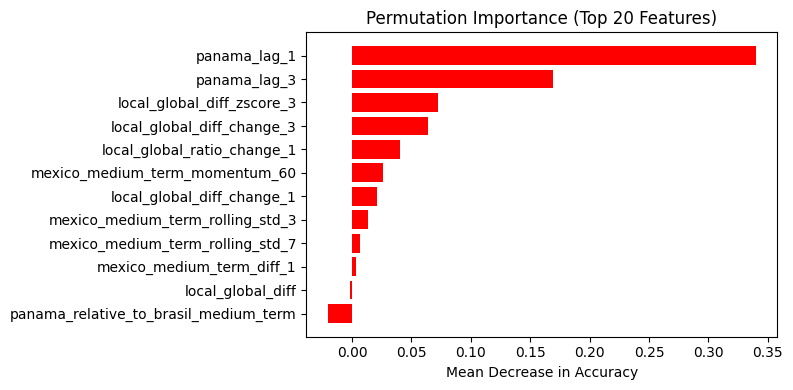

Top 20 Feature Names:
panama_lag_1
panama_lag_3
local_global_diff_zscore_3
local_global_diff_change_3
local_global_ratio_change_1
mexico_medium_term_momentum_60
local_global_diff_change_1
mexico_medium_term_rolling_std_3
mexico_medium_term_rolling_std_7
mexico_medium_term_diff_1
local_global_diff
panama_relative_to_brasil_medium_term


In [140]:
# Create the plot
plt.figure(figsize=(8, 4))

# Get the top 15 (or fewer) important features
num_features_to_plot = min(20, len(feature_importance))
top_indices = sorted_idx[-num_features_to_plot:]

# Plot only the top features
plt.barh(range(num_features_to_plot), feature_importance[top_indices],color='red')
plt.yticks(range(num_features_to_plot), [feature_names[i] for i in top_indices])
plt.xlabel('Mean Decrease in Accuracy')
plt.title('Permutation Importance (Top 20 Features)')
plt.tight_layout()
plt.show()

# Print the names of the top features
print("Top 20 Feature Names:")
for i in reversed(top_indices):
    print(feature_names[i])

In [141]:
y_test_pred_lg_class = reg_best.predict(non_seen_test_data[feature_names])

In [142]:
test_lg_test =non_seen_test_data.copy()
test_lg_test['target_name'] = target_to_use_test
test_lg_test ["date"]=non_seen_test_data.date
test_lg_test ["set_type"]='test'

In [143]:
test_lg_test["spread_predicho"] = y_test_pred_lg_class

In [144]:
# Calculate performance metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
import numpy as np
mae = mean_absolute_error(test_lg_test.target_1day, test_lg_test.spread_predicho)
mse = mean_squared_error(test_lg_test.target_1day, test_lg_test.spread_predicho)
rmse = np.sqrt(mse)
r2 = r2_score(test_lg_test.target_1day, test_lg_test.spread_predicho)
evs = explained_variance_score(test_lg_test.target_1day, test_lg_test.spread_predicho)

In [145]:
# Calculate MAPE
mape = np.mean(np.abs((test_lg_test.target_1day - test_lg_test.spread_predicho) / test_lg_test.target_1day)) * 100

In [146]:
# Print the results
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R²) Score: {r2:.4f}")
print(f"Explained Variance Score: {evs:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}%")

Mean Absolute Error (MAE): 0.1411
Mean Squared Error (MSE): 0.0315
Root Mean Squared Error (RMSE): 0.1776
R-squared (R²) Score: 0.2974
Explained Variance Score: 0.4464
Mean Absolute Percentage Error (MAPE): 4.7213%


In [147]:
test_lg_test['spread_predicho'].tail(10)

92     2.736286
93     2.844147
94     2.694784
95     2.595542
96     2.559838
97     2.543171
98     2.670105
99     2.583845
100    2.643235
101    2.658907
Name: spread_predicho, dtype: float64

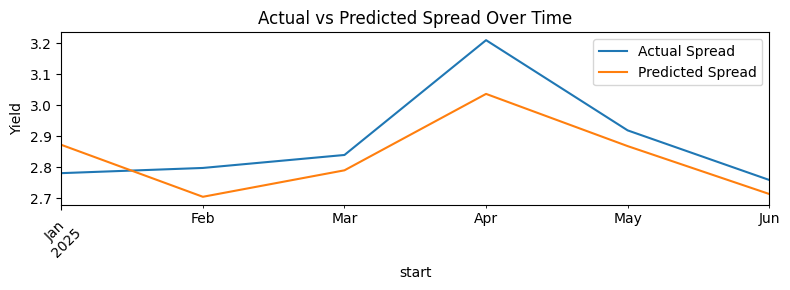

In [148]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 3))

# Plot actual yield
test_lg_test.groupby(test_lg_test['date'].dt.to_period('M'))['target_name'].mean().plot(ax=ax, label='Actual Spread')

# Plot predicted yield
test_lg_test.groupby(test_lg_test['date'].dt.to_period('M'))['spread_predicho'].mean().plot(ax=ax, label='Predicted Spread')

# Set x-axis to display dates
ax.set_xlabel('start')
ax.set_ylabel('Yield')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add title and legend
plt.title('Actual vs Predicted Spread Over Time')
plt.legend()

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Show the plot
plt.show()

In [149]:
# full data set
full_data_set = df.copy()
print(full_data_set.shape)

(2813, 12)


In [150]:
#apply feature enginering to full_data_set
full_data_set = feature_engineering(full_data_set)

C:\Users\dsosa\AppData\Local\Temp\ipykernel_9188\3081945255.py:86: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  new_features[f'panama_lag_{lag}'] = df['panama'].shift(lag).fillna(method='bfill')


In [151]:
full_data_pred = reg_best.predict(full_data_set[final_features_columns])

In [152]:
data_pred =full_data_set.copy()
data_pred['target_name'] =full_data_set.target_1day
data_pred ["date"]=full_data_set.date

In [153]:
data_pred["spread_predicho"] = full_data_pred

In [154]:
#filter by date
data_pred = data_pred[data_pred['date'] >= '2019-01-01']

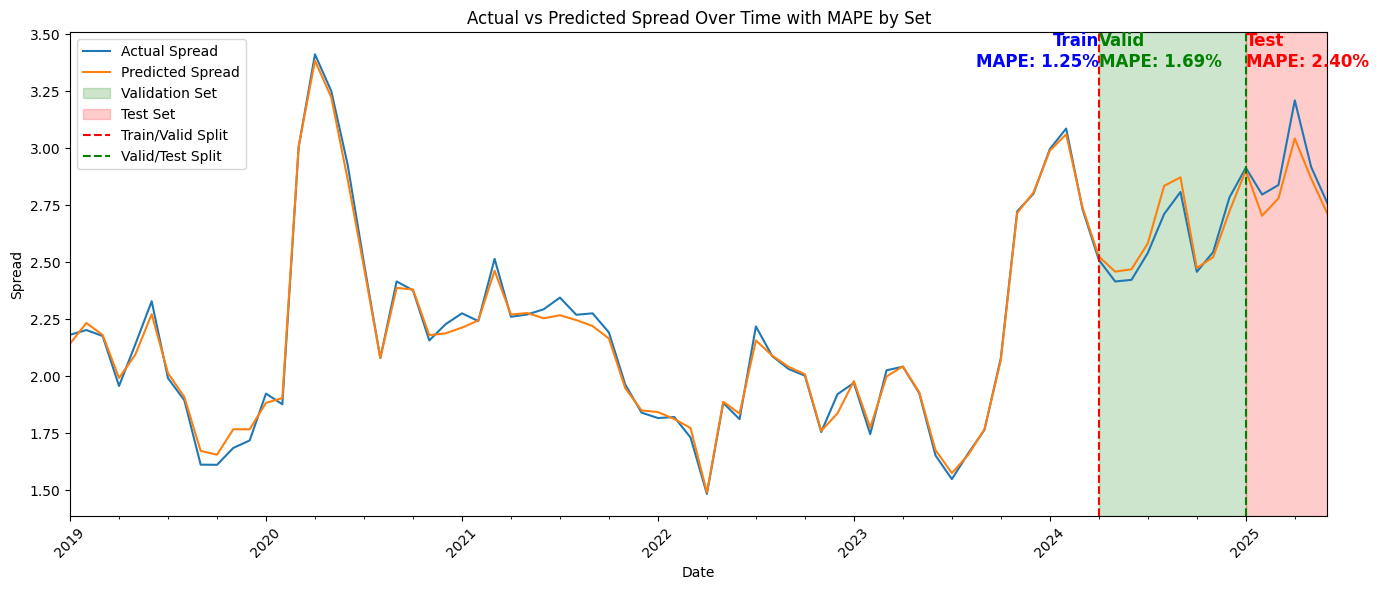

In [155]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(14, 6))

# Group data by month and calculate mean
monthly_data = data_pred.groupby(data_pred['date'].dt.to_period('M')).agg({
    'target_name': 'mean',
    'spread_predicho': 'mean'
})

# Plot actual yield
monthly_data['target_name'].plot(ax=ax, label='Actual Spread')

# Plot predicted yield
monthly_data['spread_predicho'].plot(ax=ax, label='Predicted Spread')

# Set x-axis to display dates
ax.set_xlabel('Date')
ax.set_ylabel('Spread')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add title and legend
plt.title('Actual vs Predicted Spread Over Time with MAPE by Set')
plt.legend()

# Define train/valid/test split dates
train_end = pd.to_datetime('2024-04-29')  # Adjust this date as needed
valid_end = pd.to_datetime('2025-01-30')  # Adjust this date as needed

# Add shaded areas for validation and test sets
plt.axvspan(train_end, valid_end, alpha=0.2, color='green', label='Validation Set')
plt.axvspan(valid_end, ax.get_xlim()[1], alpha=0.2, color='red', label='Test Set')

# Add vertical lines for train/valid/test separation
plt.axvline(x=train_end, color='r', linestyle='--', label='Train/Valid Split')
plt.axvline(x=valid_end, color='g', linestyle='--', label='Valid/Test Split')

# Calculate MAPE for each set
def calculate_mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual)) * 100

train_mape = calculate_mape(monthly_data.loc[:train_end, 'target_name'],
                            monthly_data.loc[:train_end, 'spread_predicho'])
valid_mape = calculate_mape(monthly_data.loc[train_end:valid_end, 'target_name'],
                            monthly_data.loc[train_end:valid_end, 'spread_predicho'])
test_mape = calculate_mape(monthly_data.loc[valid_end:, 'target_name'],
                           monthly_data.loc[valid_end:, 'spread_predicho'])

# Add text annotations with highlighted letters
plt.text(train_end, ax.get_ylim()[1], f'Train\nMAPE: {train_mape:.2f}%',
         ha='right', va='top', fontsize=12, color='blue', fontweight='bold')
plt.text(train_end, ax.get_ylim()[1], f'Valid\nMAPE: {valid_mape:.2f}%',
         ha='left', va='top', fontsize=12, color='green', fontweight='bold')
plt.text(valid_end, ax.get_ylim()[1], f'Test\nMAPE: {test_mape:.2f}%',
         ha='left', va='top', fontsize=12, color='red', fontweight='bold')

# Update legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Show the plot
plt.show()

In [156]:
data_pred.spread_predicho.describe()

count    1688.000000
mean        2.253282
std         0.459528
min         1.310559
25%         1.907433
50%         2.187685
75%         2.564952
max         3.972626
Name: spread_predicho, dtype: float64

In [157]:
#filter data_pred last year
data_pred = data_pred[data_pred['date'] >= '2024-06-01']

In [158]:
# Convert final_features_columns to a list if it's not already
if not isinstance(final_features_columns, list):
    final_features_columns = final_features_columns.tolist()

# Now concatenate the lists
columns_to_select = final_features_columns + ['date', 'target_name', 'spread_predicho']

In [159]:
# Print the last 10 rows of the selected columns
data_pred[columns_to_select].tail(5)

local_global_diff_change_1  mexico_medium_term_rolling_std_7  \
2808                    0.001900                          0.042889   
2809                   -0.178400                          0.039932   
2810                   -0.098000                          0.032295   
2811                    0.000000                          0.029477   
2812                    0.013571                          0.035031   

      local_global_diff_zscore_3  mexico_medium_term_rolling_std_3  \
2808                    0.584426                          0.014060   
2809                   -1.154651                          0.032716   
2810                   -0.890567                          0.037284   
2811                   -0.577350                          0.004330   
2812                    1.154701                          0.015204   

      local_global_ratio_change_1  mexico_medium_term_diff_1  panama_lag_1  \
2808                     0.000758                  -0.008667        2.5075   
2809                    -0.066468                   0.060500        2.5056   
2810                    -0.035226                   0.007500        2.6840   
2811                     0.000000                   0.000000        2.7820   
2812                     0.004902                   0.026333        2.7820   

      panama_lag_3  panama_relative_to_brasil_medium_term  local_global_diff  \
2808      2.655500                               1.370866           0.554400   
2809      2.738625                               1.441267           0.376000   
2810      2.507500                               1.490890           0.278000   
2811      2.505600                               1.490890           0.278000   
2812      2.684000                               1.475708           0.291571   

      mexico_medium_term_momentum_60  local_global_diff_change_3       date  \
2808                       -0.137674                    0.149900 2025-06-16   
2809                       -0.102069                    0.054625 2025-06-17   
2810                       -0.099888                   -0.274500 2025-06-18   
2811                       -0.099888                   -0.276400 2025-06-19   
2812                       -0.117293                   -0.084429 2025-06-20   

      target_name  spread_predicho  
2808     2.684000         2.543171  
2809     2.782000         2.670105  
2810     2.782000         2.583845  
2811     2.768429         2.643235  
2812     2.577000         2.658907

# Error

In [160]:
#difference between target_1day and spread_predicho
error = data_pred[['date']].copy()
error['error'] = data_pred['spread_predicho'] - data_pred['target_name']

In [161]:
#set index
error.set_index('date', inplace=True)

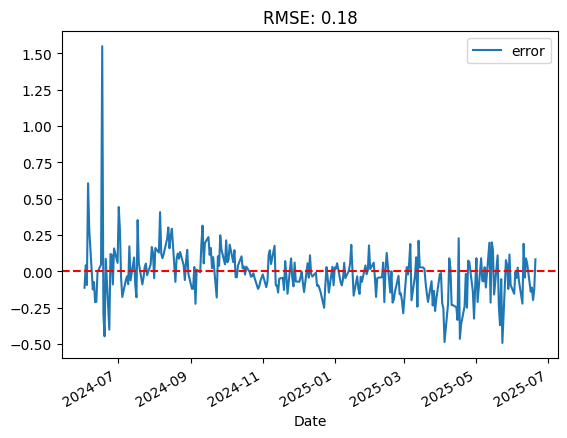

In [162]:
error.plot()
plt.axhline(0, color='red', linestyle='--')
plt.title('Error')
plt.xlabel('Date')
# compute rmse
rmse = np.sqrt(np.mean(error['error']**2))
# write rmse in the title
plt.title(f'RMSE: {rmse:.2f}')
plt.show()

<Axes: xlabel='error', ylabel='Density'>

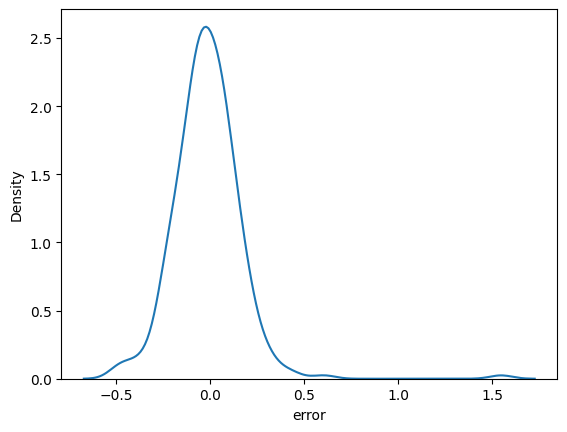

In [163]:
sns.kdeplot(error['error'])

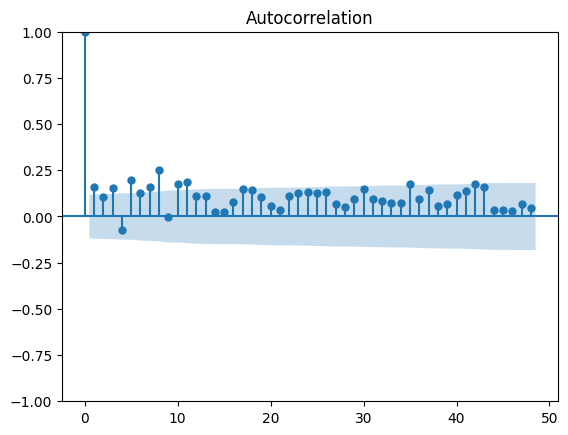

In [164]:
# make an ACF plot of error
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(error['error'], lags=48)
plt.show()

In [165]:
# make a KS statistics between data_pred['spread_predicho'] vs data_pred['target_1day']
from scipy.stats import ks_2samp
ks_stat, p_value = ks_2samp(data_pred['spread_predicho'], data_pred['target_name'])
print(f"KS Statistic: {ks_stat}")
# interpret the result of ks_stat
alpha = 0.05
if p_value > alpha:
	print('Same distribution (fail to reject H0)')
else:
	print('Different distribution (reject H0)')

KS Statistic: 0.06204379562043796
Same distribution (fail to reject H0)


# Train Full Model with train + validation data

In [166]:
# Combine training and validation data
X_combined = pd.concat([X_train_cv_final, X_validation_final, X_test])
Y_combined = pd.concat([Y_train_cv, Y_validation, Y_test])

In [167]:
X_test.shape

(102, 643)

In [168]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, r2_score
import joblib

# Combine training and validation data
X_combined = pd.concat([X_train_cv_final, X_validation_final, X_test[final_features_columns]])
Y_combined = pd.concat([Y_train_cv, Y_validation, Y_test])

# Ensure the data is sorted by date if necessary
X_combined = X_combined.sort_index()
Y_combined = Y_combined.sort_index()

# Create the final model with best parameters
final_model = lgb.LGBMRegressor(**best_params, random_state=314)

# Train the final model on the combined dataset
final_model.fit(X_combined, Y_combined)

[LightGBM] [Info] Total Bins 3527
[LightGBM] [Info] Number of data points in the train set: 2449, number of used features: 12
[LightGBM] [Info] Start training from score 2.402485


LGBMRegressor(boosting_type='dart',
              colsample_bytree=np.float64(0.9538424581137495),
              force_col_wise=True, learning_rate=0.2, max_bin=294, max_depth=6,
              min_child_samples=43, min_child_weight=0.1, min_split_gain=0,
              n_estimators=636, num_leaves=7, random_state=314, reg_alpha=0,
              reg_lambda=0, subsample=np.float64(0.6906875722436032),
              use_missing=False, zero_as_missing=True)

In [169]:
#save in model path
model_path = "C:/Users/dsosa/Documents/augment-projects/cbonds-comparables/models/medium_term"

In [170]:
#save mode in .sav format in model_path
joblib.dump(final_model, os.path.join(model_path, 'final_lgbm_model_medium_term.sav'))

['C:/Users/dsosa/Documents/augment-projects/cbonds-comparables/models/medium_term\\final_lgbm_model_medium_term.sav']